## Fit a 2D model to the gradient and look at the residuals

The fit is based on the kinematic fit from Patricio et al 2018

    lensed_gradient
    convolve_gradient_with_seeing
    bin_gradient_as_data
    compare_gradient_with_data 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='dark')

from scipy import stats
from scipy.stats import binned_statistic
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy import cosmology as co
import astropy.units as uu
from astropy.stats import median_absolute_deviation, sigma_clipped_stats
from astropy.convolution import convolve,Gaussian2DKernel,Moffat2DKernel
from reproject import reproject_interp

from lmfit import Parameters
import time
import pickle
import emcee
import corner

import warnings
warnings.filterwarnings('ignore')

cd = co.FlatLambdaCDM(H0=70*uu.km/(uu.megaparsec * uu.s), Om0=0.3, Tcmb0 = 2.725*uu.K,\
                          Neff=3.05, m_nu=[0., 0., 0.06]*uu.eV, Ob0 = 0.0483)

In [2]:
def check_convergence(pickle_file):

    res = pickle.load(open(pickle_file+".pickle",'rb'))    

    print('Fitted parameters: %s'%res['fitted_parameters'])

    chain = res['chain']
    ln = res['lnprobability']
    nwalk = ln.shape[0]
    ndim = len(res['fitted_parameters'])


    fig1, ax = plt.subplots(1,ndim+1,figsize=(14,4))
    ax = ax.ravel()
    for j in range(nwalk):
        ax[0].plot(ln[j, :])
        ax[0].set_title('lnP')
    
    for i in range(ndim):
        for j in range(nwalk):
            ax[i+1].plot(chain[j, :, i])
            ax[i+1].set_title(res['fitted_parameters'][i])

    return fig1

def make_cornerplot(pickle_file,start):
    """ start: chain steps below this value are not included in the plot"""
   
    res = pickle.load(open(pickle_file+".pickle",'rb'))

    chain = res['chain']
    ndim = len(res['fitted_parameters'])
    samples = chain[:, start:, :].reshape((-1, ndim))

    best_par = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))

    fig = corner.corner(samples, labels=res['fitted_parameters'],truths=np.array(best_par).T[0],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True)

    for n,v in zip(res['fitted_parameters'],best_par):
        print('%s %0.4f$^{+%0.4f}_{-%0.4f}$'%(n,v[0],v[1],v[2]))

    if len(res['fitted_parameters']) == 7:
        print('input to make_2d_plot')
        print('%0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f '
                %(best_par[0][0],best_par[1][0],best_par[2][0],best_par[3][0],best_par[4][0],best_par[5][0],best_par[6][0]))

    return fig

def plot_best_solution_fixed_dist_map(dexperkpc,peakmet,data_path,uncertainty_path,dist_path,seeing_fwhm_pix,max_radius):
                                         
    # Load data
    data = fits.getdata(data_path)
    data_header = fits.getheader(data_path)
    unc = fits.getdata(uncertainty_path)
    dist_map, _ = reproject_interp(dist_path,data_header)
    bad_pix = np.where((dist_map == 0.0) | (dist_map  >= max_radius ))
                       
    lensed_grad = dist_map *  dexperkpc + peakmet
    lensed_grad[bad_pix] = np.nan
    convolved_grad = convolve_gradient_with_seeing(lensed_grad,seeing_fwhm_pix)
    convolved_grad[bad_pix] = np.nan
    
    fig, ax = plt.subplots(1,5,figsize=(12,3))
    cax = ax[0].imshow(data,origin='lower')
    plt.colorbar(cax,ax=ax[0])
    cxa = ax[1].imshow(lensed_grad,origin='lower')
    plt.colorbar(cax,ax=ax[1])
    cxa = ax[2].imshow(convolved_grad,origin='lower')
    plt.colorbar(cax,ax=ax[2])
    cax = ax[3].imshow(data-lensed_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[3])
    cax = ax[4].imshow(data-convolved_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[4])
    print('residuals',median_absolute_deviation(data-convolved_grad,ignore_nan=True))
    print('residuals',median_absolute_deviation((data-convolved_grad)/unc,ignore_nan=True))
    print('residuals',median_absolute_deviation(data-lensed_grad,ignore_nan=True))
    print('residuals',median_absolute_deviation((data-lensed_grad)/unc,ignore_nan=True))

In [3]:
def prepare_displacement_maps(dplx_path,dply_path,data_path,z):
    
    data_header = fits.getheader(data_path)
    dplx = fits.getdata(dplx_path)
    dply = fits.getdata(dply_path)
    dpl_header = fits.getheader(dplx_path)
    
    step = abs(dpl_header['CDELT2'])*3600.0
    sx = -1.0*dplx
    sy = -1.0*dply
    X,Y = np.meshgrid(xrange(dplx.shape[0]),xrange(dplx.shape[1]))
    sx += X*step
    sy += Y*step
    sxmodel, _ = reproject_interp((sx,dpl_header),data_header) # these are the displacements in arcsec
    symodel, _ = reproject_interp((sy,dpl_header),data_header)
    sxmodel = sxmodel/cd.arcsec_per_kpc_proper(z).value
    symodel = symodel/cd.arcsec_per_kpc_proper(z).value
    
    return sxmodel,symodel

def lensed_distance_map(cx,cy,ellip,theta,rflat,data_shape,sxmodel,symodel):
    ''' Makes a gradient in source plane and leses it back to image plane.
    Parameters:
    -----------
    dexperkpc: float
        slope of the gradient in dex/kpc
    peakmet: float
        central metallicity value
    data_wcs: astropy.wcs
        WCS object from data (to align displacement maps)
    dplx,dply: 2d array
        displacement maps (from lenstool)
    dpl_header: astropy.header
        header of the displacement maps (doesn't matter which, if they are aligned, which they should)
    cx,cy: int
        center of the gradient in image plane
    ellip: float
        ellipticity, defined as in astropy
    theta: float
        position angle, defined as in astropy
    kpcperpix: float
        kpc per pixel in the data image
    Output:
    -------
    2d array (gradient in image plane)
    '''
    
    def centre_displacement_map(sxmodel,symodel,cx,cy):        
        center_x = sxmodel[cy,cx] 
        center_y = symodel[cy,cx] 
        centered_sx = (sxmodel - center_x)
        centered_sy = (symodel - center_y)
        return centered_sx, centered_sy

    lensmodelx, lensmodely = centre_displacement_map(sxmodel,symodel,cx,cy)
    
    # Create 2D model
    y_ip,x_ip = np.mgrid[:data_shape[0], :data_shape[1]]
    x_all = lensmodelx[y_ip,x_ip]
    y_all = lensmodely[y_ip,x_ip]
    
    # include rotation
    x_rot = x_all*np.cos(theta)+y_all*np.sin(theta) 
    y_rot = y_all*np.cos(theta)-x_all*np.sin(theta)
    dist = np.sqrt((x_rot)**2+((y_rot)/ellip)**2)
            
    return dist

In [10]:
def bin_gradient_and_data(aligned_model,data,uncertainty,voronoi_map):
    """ Assumes the voronoi binning was done in the 'data' file.
    Returns a flat arrray of both the model and the data, corresponding to the same binning"""
    model_flt = []
    data_flt = []
    unc_flt = []
    for bin_nb in np.unique(voronoi_map):
        sel_pix = np.where(voronoi_map == bin_nb)    
        model_flt.append(np.nanmean(aligned_model[sel_pix]))
        data_flt.append(np.nanmean(data[sel_pix]))
        unc_flt.append(np.nanmean(uncertainty[sel_pix]))

    return np.array(model_flt),np.array(data_flt),np.array(unc_flt)

In [24]:
seeing_fwhm_pix = 1.03/0.2
flux_map,_    = reproject_interp('../../Data/HST/AS1063_F814w.fits',fits.getheader('Maps/Map_metallicity.fits'))
flux_map_conv = convolve(flux_map,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')

def weighted_convolution(lensed_grad,seeing_fwhm_pix):
    seeing_sigma = seeing_fwhm_pix/2.355
    
    # transform metallicity from logrithm to linear form
    linear_grad = 10**(lensed_grad)
    
    # Convolve with weights
    conv_grad = convolve(linear_grad*flux_map,Gaussian2DKernel(seeing_sigma),boundary='extend')/flux_map_conv
    
    return np.log10(conv_grad)

In [11]:
def fit_gradient(data_path,uncertainty_path,dplx_path,dply_path,z,seeing_fwhm_pix,voronoi_path,parameters,nsteps,outputname):

    start_time = time.time()
    
    # Load data
    data = fits.getdata(data_path)
    data_header = fits.getheader(data_path)
    data_shape = data.shape
    unc = fits.getdata(uncertainty_path)
    dplx = fits.getdata(dplx_path)
    dply = fits.getdata(dply_path)
    dpl_header = fits.getheader(dplx_path)
    voronoi_map = fits.getdata(voronoi_path)
    
    # Massage displacement maps
    sxmodel,symodel = prepare_displacement_maps(dplx_path,dply_path,data_path,z)
    
    # Check which parameters are varied
    parameter_names = [] # array because emcee varies it
    starting_point = []
    starting_low = []
    starting_high = []
    fixed_parameters = {} # dictionary
    for key in parameters.keys():
        if parameters[key].vary:
            parameter_names.append(key)
            starting_point.append(parameters[key].value)
            starting_high.append(parameters[key].max)
            starting_low.append(parameters[key].min)
        else:
            fixed_parameters[key] = parameters[key].value

    ndim = len(parameter_names)
    print('Fixed parameters: %s '%fixed_parameters)
    
    # Priors: uniform
    def lnprior(par):
        for par_value,par_name in zip(par,parameter_names):
            if par_value < parameters[par_name].min or par_value > parameters[par_name].max:
                return -np.inf
        return 0
    
    # Log likelihood function
    def lnprob(par,parameter_names,fixed_parameters):
        
        lp = lnprior(par)

        # this makes is slightly faster cause it avoids actually calculating stuff where the parameters are out of bounderies
        if lp == -np.inf: 
            return lp
        
        else:
            # Fill in parameters that are varied
            for par_value,par_name in zip(par,parameter_names): 
                if par_name == 'dexperkpc': 
                    dexperkpc = par_value
                elif par_name == 'peakmet':            
                    peakmet = par_value
                elif par_name == 'rflat':            
                    rflat = par_value
                elif par_name == 'cx':            
                    cx = par_value
                elif par_name == 'cy':            
                    cy = par_value
                elif par_name == 'ellip':            
                    ellip = par_value
                elif par_name == 'theta':            
                    theta = par_value
                else:
                    print('Parameter name error: %s'%par_name)                    
                    
            # Add fixed parameters
            for k in fixed_parameters.keys():
                if k == 'dexperkpc': 
                    dexperkpc = fixed_parameters[k]
                elif k == 'peakmet': 
                    peakmet = fixed_parameters[k]
                elif k == 'rflat': 
                    rflat = fixed_parameters[k]
                elif k == 'cx': 
                    cx = fixed_parameters[k]
                elif k == 'cy': 
                    cy = fixed_parameters[k]
                elif k == 'ellip': 
                    ellip = fixed_parameters[k]
                elif k == 'theta': 
                    theta = fixed_parameters[k]
                else:
                    print('Fixed Parameter name error: %s'%k)

            # Create model 
            cy, cx = int(np.round(cy)), int(np.round(cx))
            lensed_dist = lensed_distance_map(cx,cy,ellip,theta,rflat,data_shape,sxmodel,symodel)  
            lensed_grad = lensed_dist * dexperkpc + peakmet
            
            # With flatenning?
            flat_pix  = np.where(lensed_dist  >= rflat )
            lensed_grad[flat_pix] = sigma_clipped_stats(data[flat_pix])[0]

            #convolved_grad = convolve(lensed_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')
            convolved_grad =  weighted_convolution(lensed_grad,seeing_fwhm_pix)
            
            binned_model, binned_data, binned_unc = bin_gradient_and_data(convolved_grad,data,unc,voronoi_map)
            
            # Compare with data
            inv_sigma2 = 1.0/(binned_unc**2)
            lnp = -0.5*(np.nansum((binned_data-binned_model)**2*inv_sigma2 - np.log(inv_sigma2*np.sqrt(2*np.pi))))
       
            return lnp + lp 
    
    # Prepare sampler
    nwalkers= 24
    print('Preparing sampler with %d walkers'%nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[parameter_names,fixed_parameters])
    p0 = [np.random.uniform(starting_low,starting_high) for i in range(nwalkers)]

    # Fitting
    nsteps = nsteps
    print('MCMCing for %d steps'%nsteps)

    for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
        if i % 50 == 0:
            print("{0:5.1%}".format(float(i) / nsteps))
            
            
    with open(outputname+".pickle",'wb') as f:
        results = {}
        results['chain'] = sampler.chain
        results['lnprobability'] = sampler.lnprobability
        results['fitted_parameters'] = parameter_names
        results['parameters'] = parameters
        pickle.dump(results,f)

    print('Execution time: %0.4f minutes'%(float(time.time() - start_time)/60))
    
    return results

In [8]:
def plot_best_solution(dexperkpc,peakmet,cx,cy,ellip,theta,rflat,data_path,uncertainty_path,dplx_path,dply_path,voronoi_path,seeing_fwhm_pix,z,free_par=7):
     
    # Load data
    data = fits.getdata(data_path)
    data_header = fits.getheader(data_path)
    data_shape = data.shape
    unc = fits.getdata(uncertainty_path)
    dplx = fits.getdata(dplx_path)
    dply = fits.getdata(dply_path)
    dpl_header = fits.getheader(dplx_path)
    voronoi_map = fits.getdata(voronoi_path)
    
    # Make gradient
    sxmodel,symodel = prepare_displacement_maps(dplx_path,dply_path,data_path,z)
    lensed_dist = lensed_distance_map(cx,cy,ellip,theta,rflat,data_shape,sxmodel,symodel)  
    lensed_grad = lensed_dist * dexperkpc + peakmet
    flat_pix  = np.where(lensed_dist  >= rflat)
    lensed_grad[flat_pix] = sigma_clipped_stats(data[flat_pix])[0]
    #convolved_grad = convolve(lensed_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')  
    convolved_grad =  weighted_convolution(lensed_grad,seeing_fwhm_pix)
    
    # Plot stuff
    fig, ax = plt.subplots(1,5,figsize=(14,3))
    ax[0].set_title('Data')
    cax = ax[0].imshow(data,origin='lower')
    plt.colorbar(cax,ax=ax[0],fraction=0.05)
    ax[0].plot(cx,cy,marker='x',color='r')
    
    ax[1].set_title('Lensed Gradient')
    cxa = ax[1].imshow(lensed_grad,origin='lower',vmin=8.5)
    plt.colorbar(cax,ax=ax[1],fraction=0.05)
    
    ax[2].set_title('Convolved Gradient')
    cxa = ax[2].imshow(convolved_grad,origin='lower',vmin=8.5)
    plt.colorbar(cax,ax=ax[2],fraction=0.05)
    
    ax[3].set_title('Data - Lensed')
    cax = ax[3].imshow(data-lensed_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[3],fraction=0.05)
    
    ax[4].set_title('Data - Convolved')
    cax = ax[4].imshow(data-convolved_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[4],fraction=0.05)
    
    #Stats
    binned_model, binned_data, binned_unc = bin_gradient_and_data(convolved_grad,data,unc,voronoi_map)
    chi2 = np.nansum((binned_data-binned_model)**2/binned_unc**2)
    inv_sigma2 = 1.0/(binned_unc**2)
    lnp = -0.5*(np.nansum((binned_data-binned_model)**2*inv_sigma2- np.log(inv_sigma2*np.sqrt(2*np.pi))))
    bic = free_par*np.log(len(binned_data)) - 2*lnp
    mad = median_absolute_deviation(binned_data-binned_model,ignore_nan=True)
    print('Chi2: %0.2f; Chi2/dof: %0.2f'%(chi2,chi2/(len(binned_data)-free_par)))
    print('Loglikelihood: %d; BIC: %d'%(lnp,bic))
    print('Median Absolute Deviation %0.6f'%mad)
    
    return lensed_grad,convolved_grad,lensed_dist

**First fit:**

In [18]:
def define_parameters():
    """This has to be edited manually."""
    p = Parameters()
    p.add_many(
    #  (Name,               Value,  Vary,    Min,     Max)
       ("dexperkpc",       -0.02,   True,   -0.1,       0),
       ("peakmet",           9.0,   True,    8.5,     9.5),
       ("rflat",            30.0,  False,    0,       100),
       ("cx",                 29,   True,     27,     31.), 
       ("cy",                 23,   True,     21,     25.),
       ("ellip",             0.5,   True,    0.1,     0.9),
       ("theta",       np.pi*3/12,  True,   -np.pi/2  , np.pi/2))
    return p
  
    
init_par = define_parameters()

fit = fit_gradient(data_path= 'Maps/Map_metallicity.fits',
             uncertainty_path = 'Maps/Map_metallicity_unc.fits',
             dplx_path = '../../Data/Lensing/AS1063/AS1063_dplx.fits',
             dply_path = '../../Data/Lensing/AS1063/AS1063_dply.fits',
             z = 0.611, 
             seeing_fwhm_pix = 1.03/0.2,
             voronoi_path = 'Maps/Map_bins_SN_70_flux_stddev.fits',
             parameters = init_par, 
             nsteps = 4000,
             outputname = 'as1063_2d_fit_test_new_convolution')

Fixed parameters: {'rflat': 30.0} 
Preparing sampler with 24 walkers
MCMCing for 4000 steps
 0.0%
 1.2%
 2.5%
 3.8%
 5.0%
 6.2%
 7.5%
 8.8%
10.0%
11.2%
12.5%
13.8%
15.0%
16.2%
17.5%
18.8%
20.0%
21.2%
22.5%
23.8%
25.0%
26.2%
27.5%
28.7%
30.0%
31.2%
32.5%
33.8%
35.0%
36.2%
37.5%
38.8%
40.0%
41.2%
42.5%
43.8%
45.0%
46.2%
47.5%
48.8%
50.0%
51.2%
52.5%
53.8%
55.0%
56.2%
57.5%
58.8%
60.0%
61.3%
62.5%
63.7%
65.0%
66.2%
67.5%
68.8%
70.0%
71.2%
72.5%
73.8%
75.0%
76.2%
77.5%
78.8%
80.0%
81.2%
82.5%
83.8%
85.0%
86.2%
87.5%
88.8%
90.0%
91.2%
92.5%
93.8%
95.0%
96.2%
97.5%
98.8%
Execution time: 42.2914 minutes


Fitted parameters: ['dexperkpc', 'peakmet', 'cx', 'cy', 'ellip', 'theta']


<IPython.core.display.Javascript object>


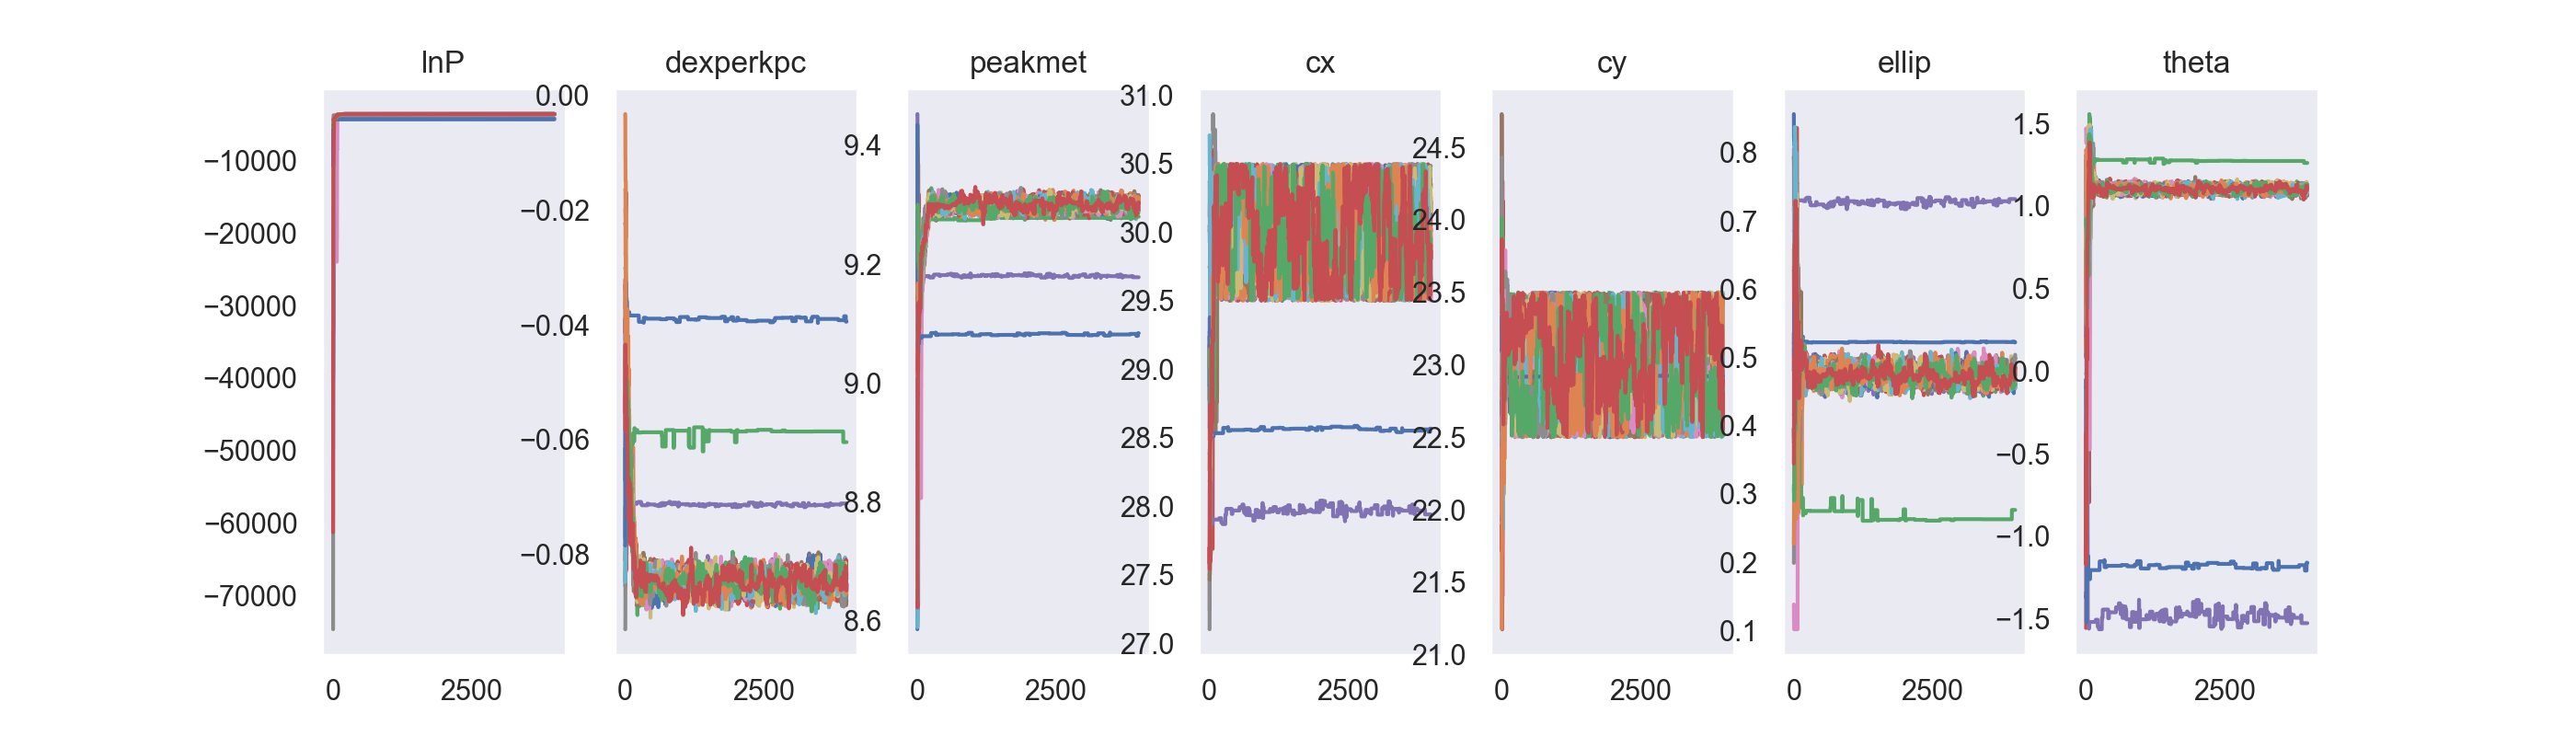

<IPython.core.display.Javascript object>


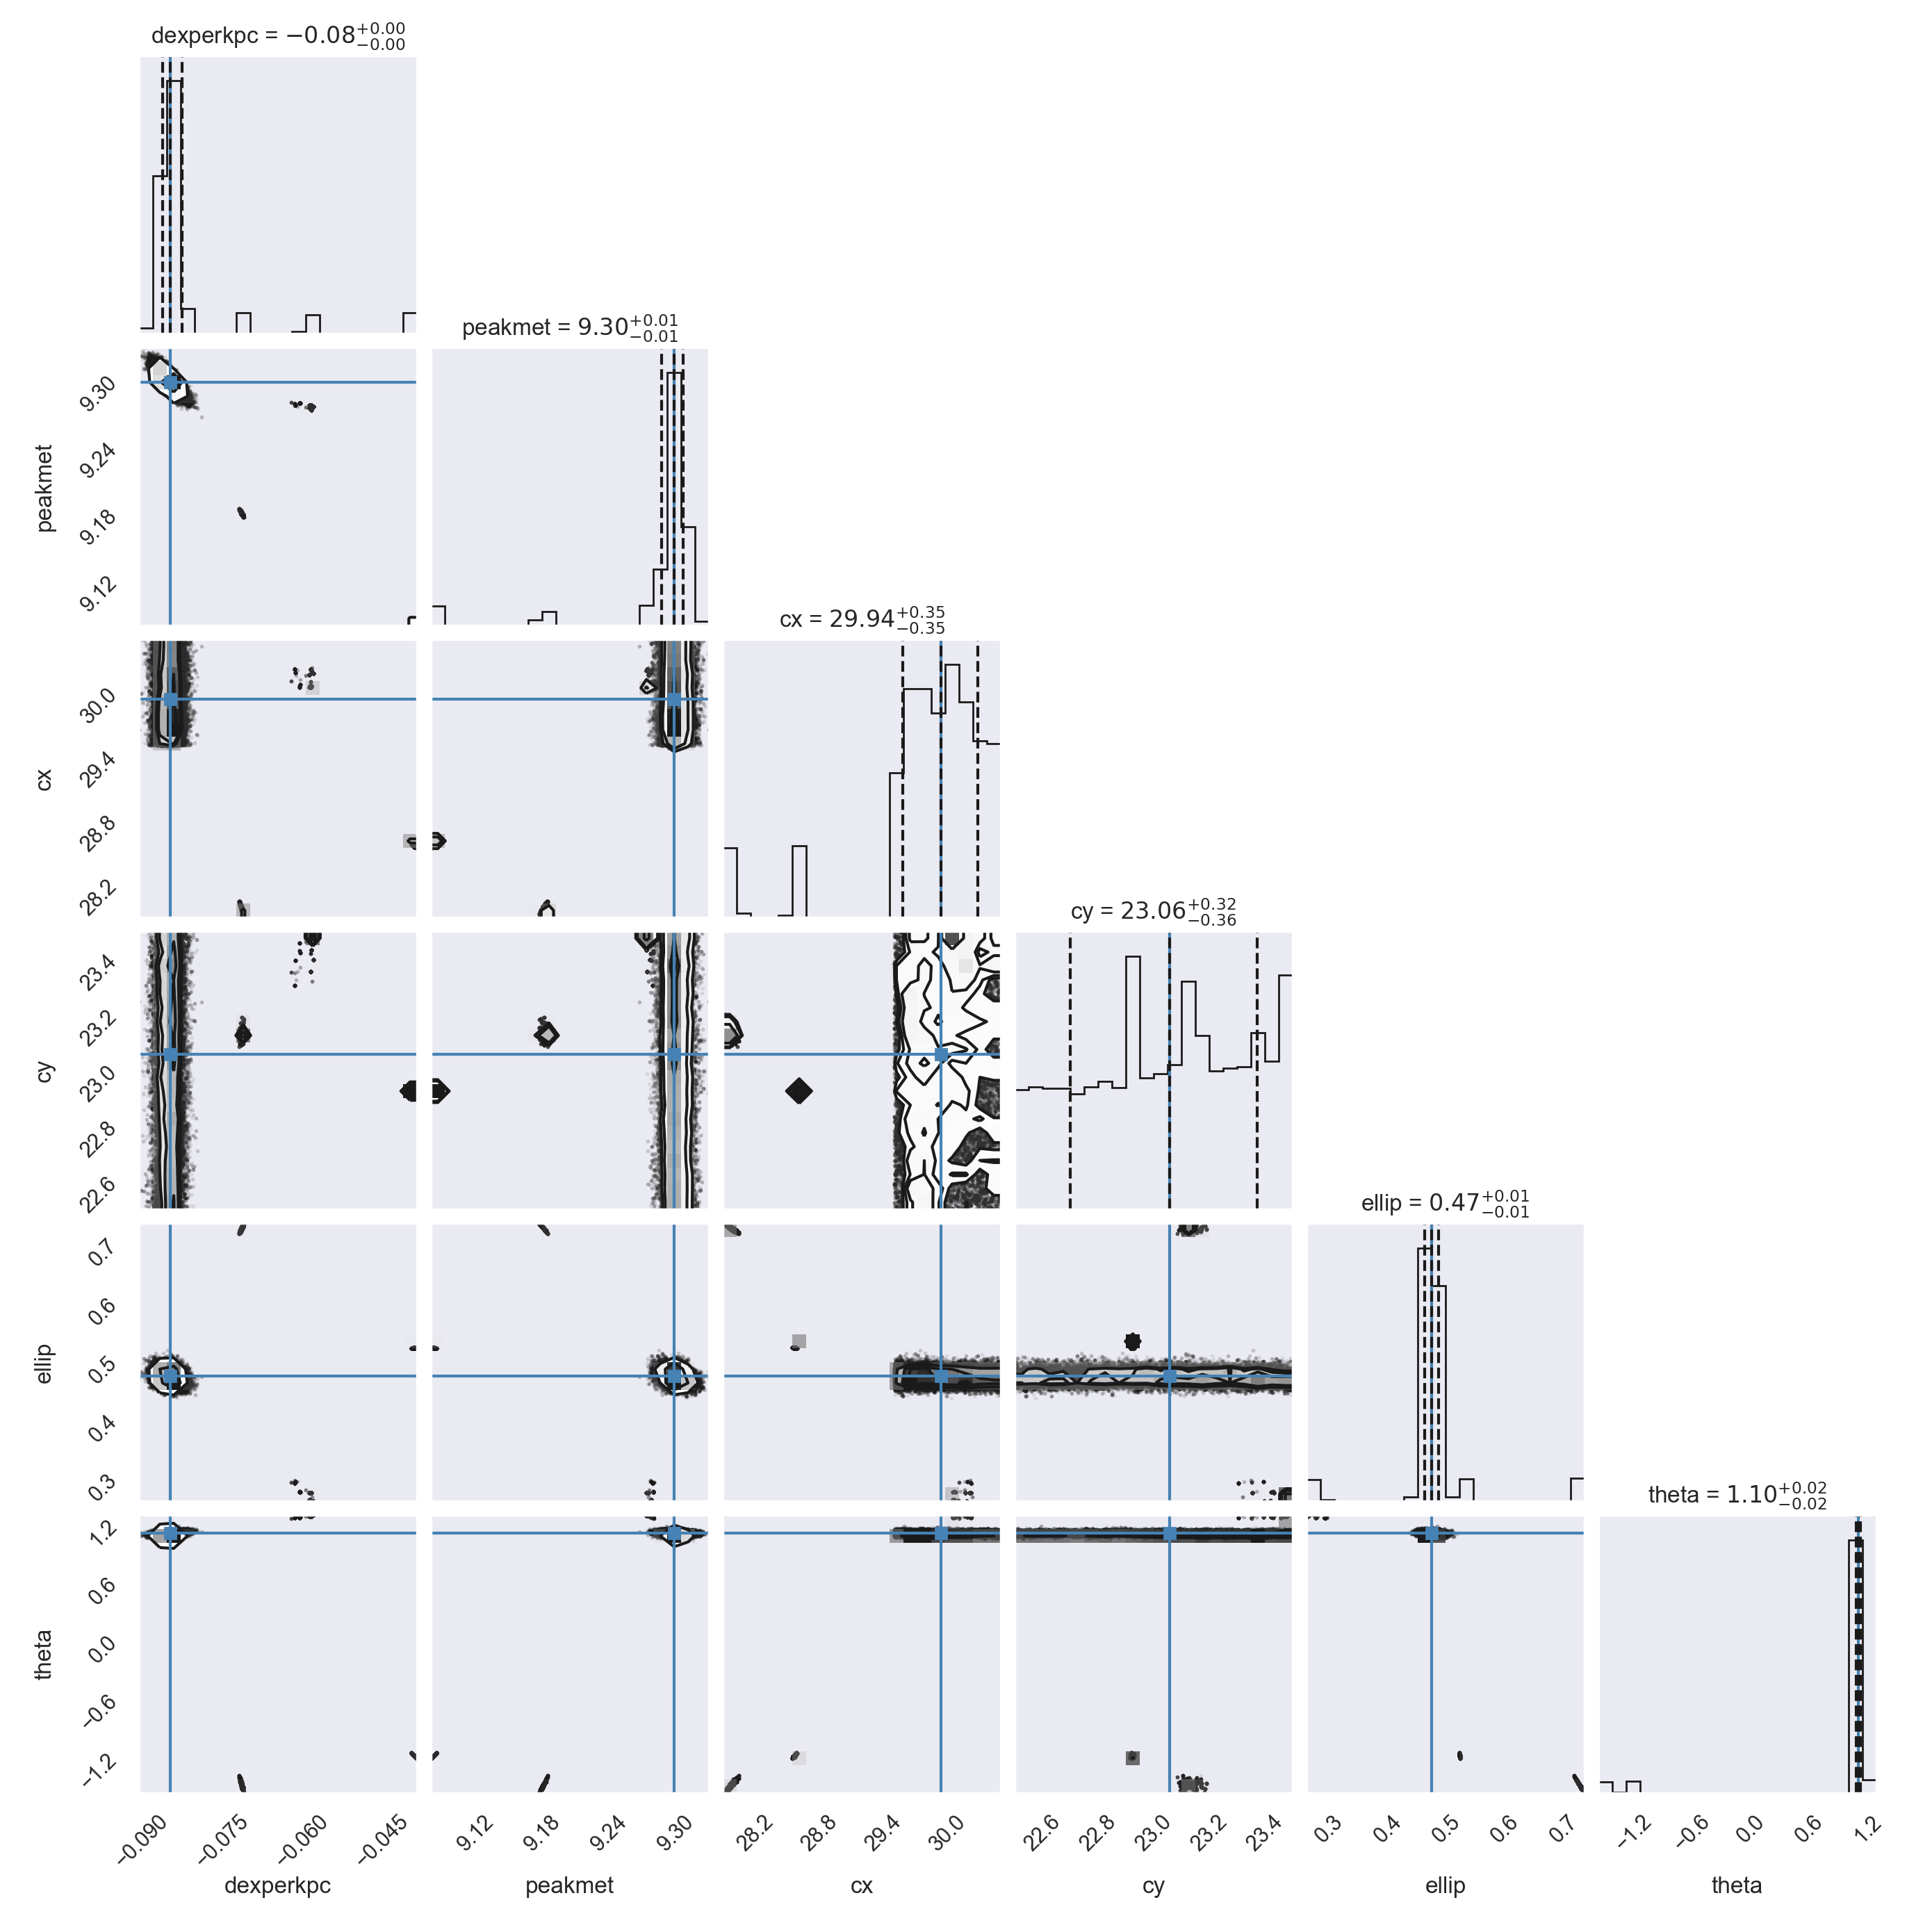

dexperkpc -0.0847$^{+0.0022}_{-0.0015}$
peakmet 9.2986$^{+0.0078}_{-0.0112}$
cx 29.9361$^{+0.3519}_{-0.3533}$
cy 23.0564$^{+0.3153}_{-0.3567}$
ellip 0.4739$^{+0.0126}_{-0.0111}$
theta 1.1016$^{+0.0185}_{-0.0216}$


In [20]:
fig1 = check_convergence('as1063_2d_fit_test_new_convolution')
fig2 = make_cornerplot('as1063_2d_fit_test_new_convolution',500)

<IPython.core.display.Javascript object>


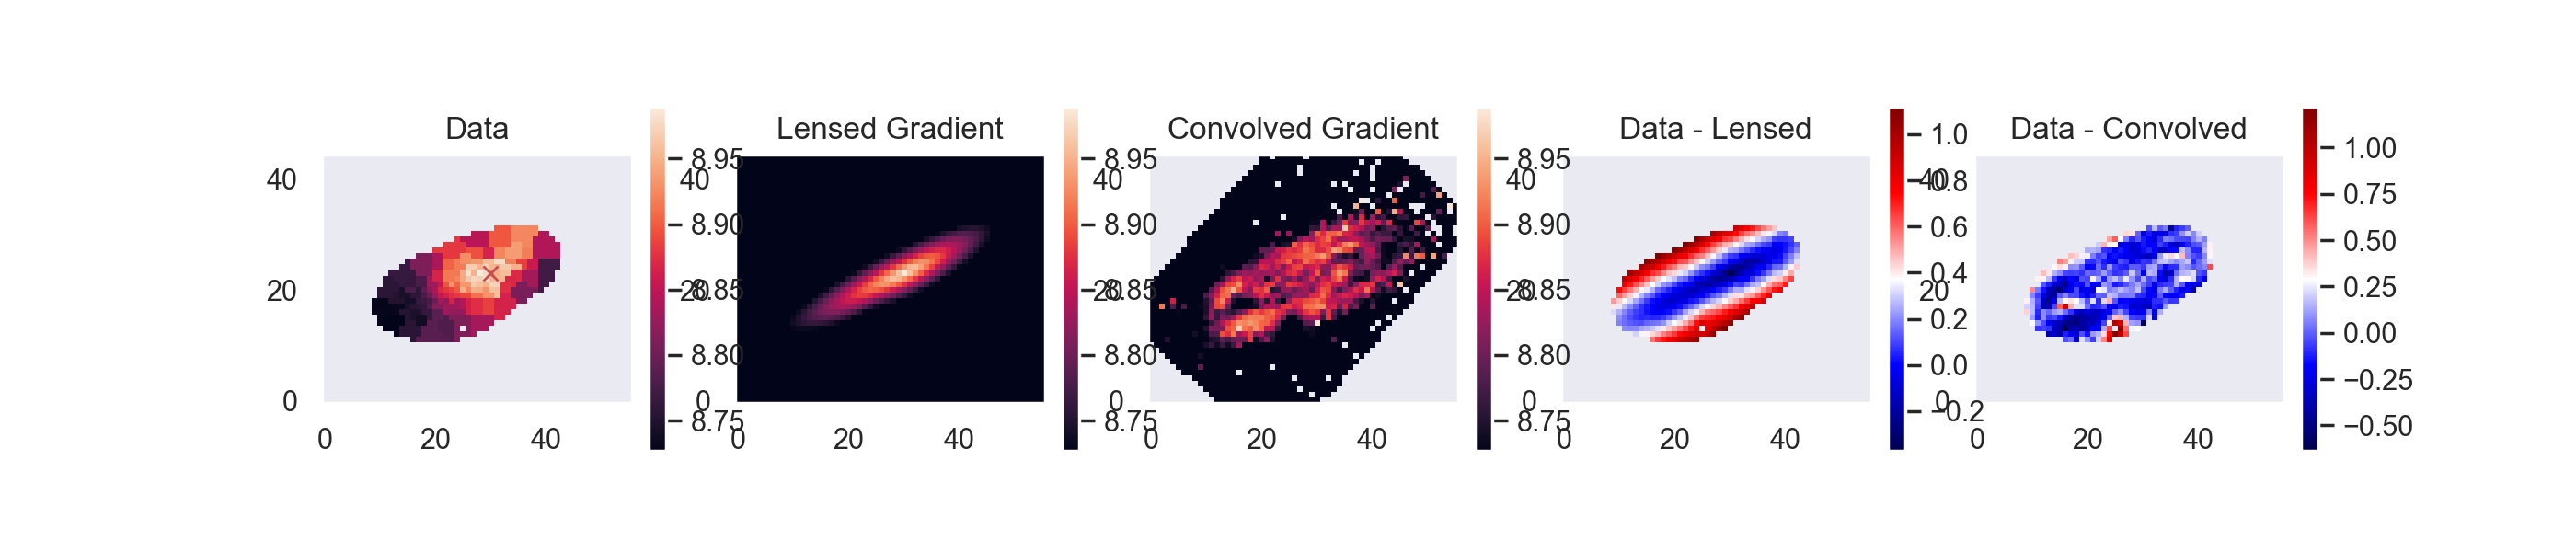

Chi2: 8347.18; Chi2/dof: 64.21
Loglikelihood: -3620; BIC: 7269
Median Absolute Deviation 0.116919


In [21]:
lens_grad,conv_grad,dist_grad = \
            plot_best_solution(dexperkpc= -0.0847 ,peakmet = 9.2986, cx = 30 ,cy = 23 ,ellip = 0.4739 ,theta = 1.1016, rflat=100,
                               free_par = 6,
                               data_path= 'Maps/Map_metallicity.fits',
                               uncertainty_path = 'Maps/Map_metallicity_unc.fits',
                               dplx_path = '../../Data/Lensing/AS1063/AS1063_dplx.fits',
                               dply_path = '../../Data/Lensing/AS1063/AS1063_dply.fits',
                               z = 0.611 , 
                               seeing_fwhm_pix = 1.03/0.2,
                               voronoi_path = 'Maps/Map_bins_SN_70_flux_stddev.fits')

#fits.writeto('Model_AS1063_gradient_new_convolution_convolved.fits',conv_grad,header=header,overwrite=True)
#fits.writeto('Model_AS1063_gradient_new_convolution.fits',lens_grad,header=header,overwrite=True)
#fits.writeto('Model_AS1063_gradient_new_convolution_distance_map.fits',dist_grad,header=header,overwrite=True)

In [16]:
def define_parameters():
    """This has to be edited manually."""
    p = Parameters()
    p.add_many(
    #  (Name,               Value,  Vary,    Min,     Max)
       ("dexperkpc",       -0.02,   True,   -0.1,       0),
       ("peakmet",           9.0,   True,    8.5,     9.5),
       ("rflat",             8.0,   True,      4,      16),
       ("cx",                 30,   True,     27,     31.),
       ("cy",                 24,   True,     21,     25.),
       ("ellip",             0.5,   True,    0.1,     0.9),
       ("theta",       np.pi*3/12,  True,    -np.pi/2  , np.pi/2))
    return p
  
    
init_par = define_parameters()

fit_gradient(data_path= 'Maps/Map_metallicity.fits',
             uncertainty_path = 'Maps/Map_metallicity_unc.fits',
             dplx_path = '../../Data/Lensing/AS1063/AS1063_dplx.fits',
             dply_path = '../../Data/Lensing/AS1063/AS1063_dply.fits',
             voronoi_path = 'Maps/Map_bins_SN_70_flux_stddev.fits',
             z = 0.611 , 
             seeing_fwhm_pix = 1.03/0.2,
             parameters = init_par,
             nsteps=2000,
             outputname = 'as1063_2Dfit_flat')

Fixed parameters: {} 
Preparing sampler with 24 walkers
MCMCing for 2000 steps
 0.0%
 2.5%
 5.0%
 7.5%
10.0%
12.5%
15.0%
17.5%
20.0%
22.5%
25.0%
27.5%
30.0%
32.5%
35.0%
37.5%
40.0%
42.5%
45.0%
47.5%
50.0%
52.5%
55.0%
57.5%
60.0%
62.5%
65.0%
67.5%
70.0%
72.5%
75.0%
77.5%
80.0%
82.5%
85.0%
87.5%
90.0%
92.5%
95.0%
97.5%
Execution time: 20.5946 minutes


{'chain': array([[[-6.75475305e-03,  8.53774594e+00,  6.75170620e+00, ...,
           2.46696982e+01,  7.83414684e-01, -1.26254786e+00],
         [-6.75475305e-03,  8.53774594e+00,  6.75170620e+00, ...,
           2.46696982e+01,  7.83414684e-01, -1.26254786e+00],
         [-6.75475305e-03,  8.53774594e+00,  6.75170620e+00, ...,
           2.46696982e+01,  7.83414684e-01, -1.26254786e+00],
         ...,
         [-2.70202018e-02,  9.06019529e+00,  1.31802416e+01, ...,
           2.36277105e+01,  5.36647453e-01, -4.86538310e-01],
         [-2.70202018e-02,  9.06019529e+00,  1.31802416e+01, ...,
           2.36277105e+01,  5.36647453e-01, -4.86538310e-01],
         [-2.70202018e-02,  9.06019529e+00,  1.31802416e+01, ...,
           2.36277105e+01,  5.36647453e-01, -4.86538310e-01]],
 
        [[-9.47916228e-02,  8.86075495e+00,  1.06213195e+01, ...,
           2.42568363e+01,  6.33137751e-01, -1.12453192e+00],
         [-9.08119556e-02,  8.84032985e+00,  1.05145950e+01, ...,
           2

Fitted parameters: ['dexperkpc', 'peakmet', 'rflat', 'cx', 'cy', 'ellip', 'theta']


<IPython.core.display.Javascript object>


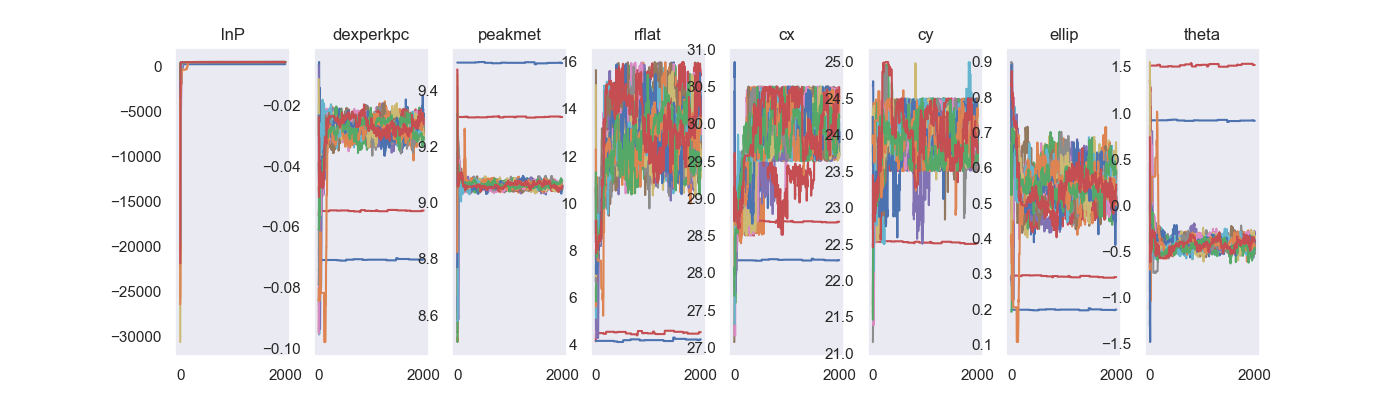

<IPython.core.display.Javascript object>


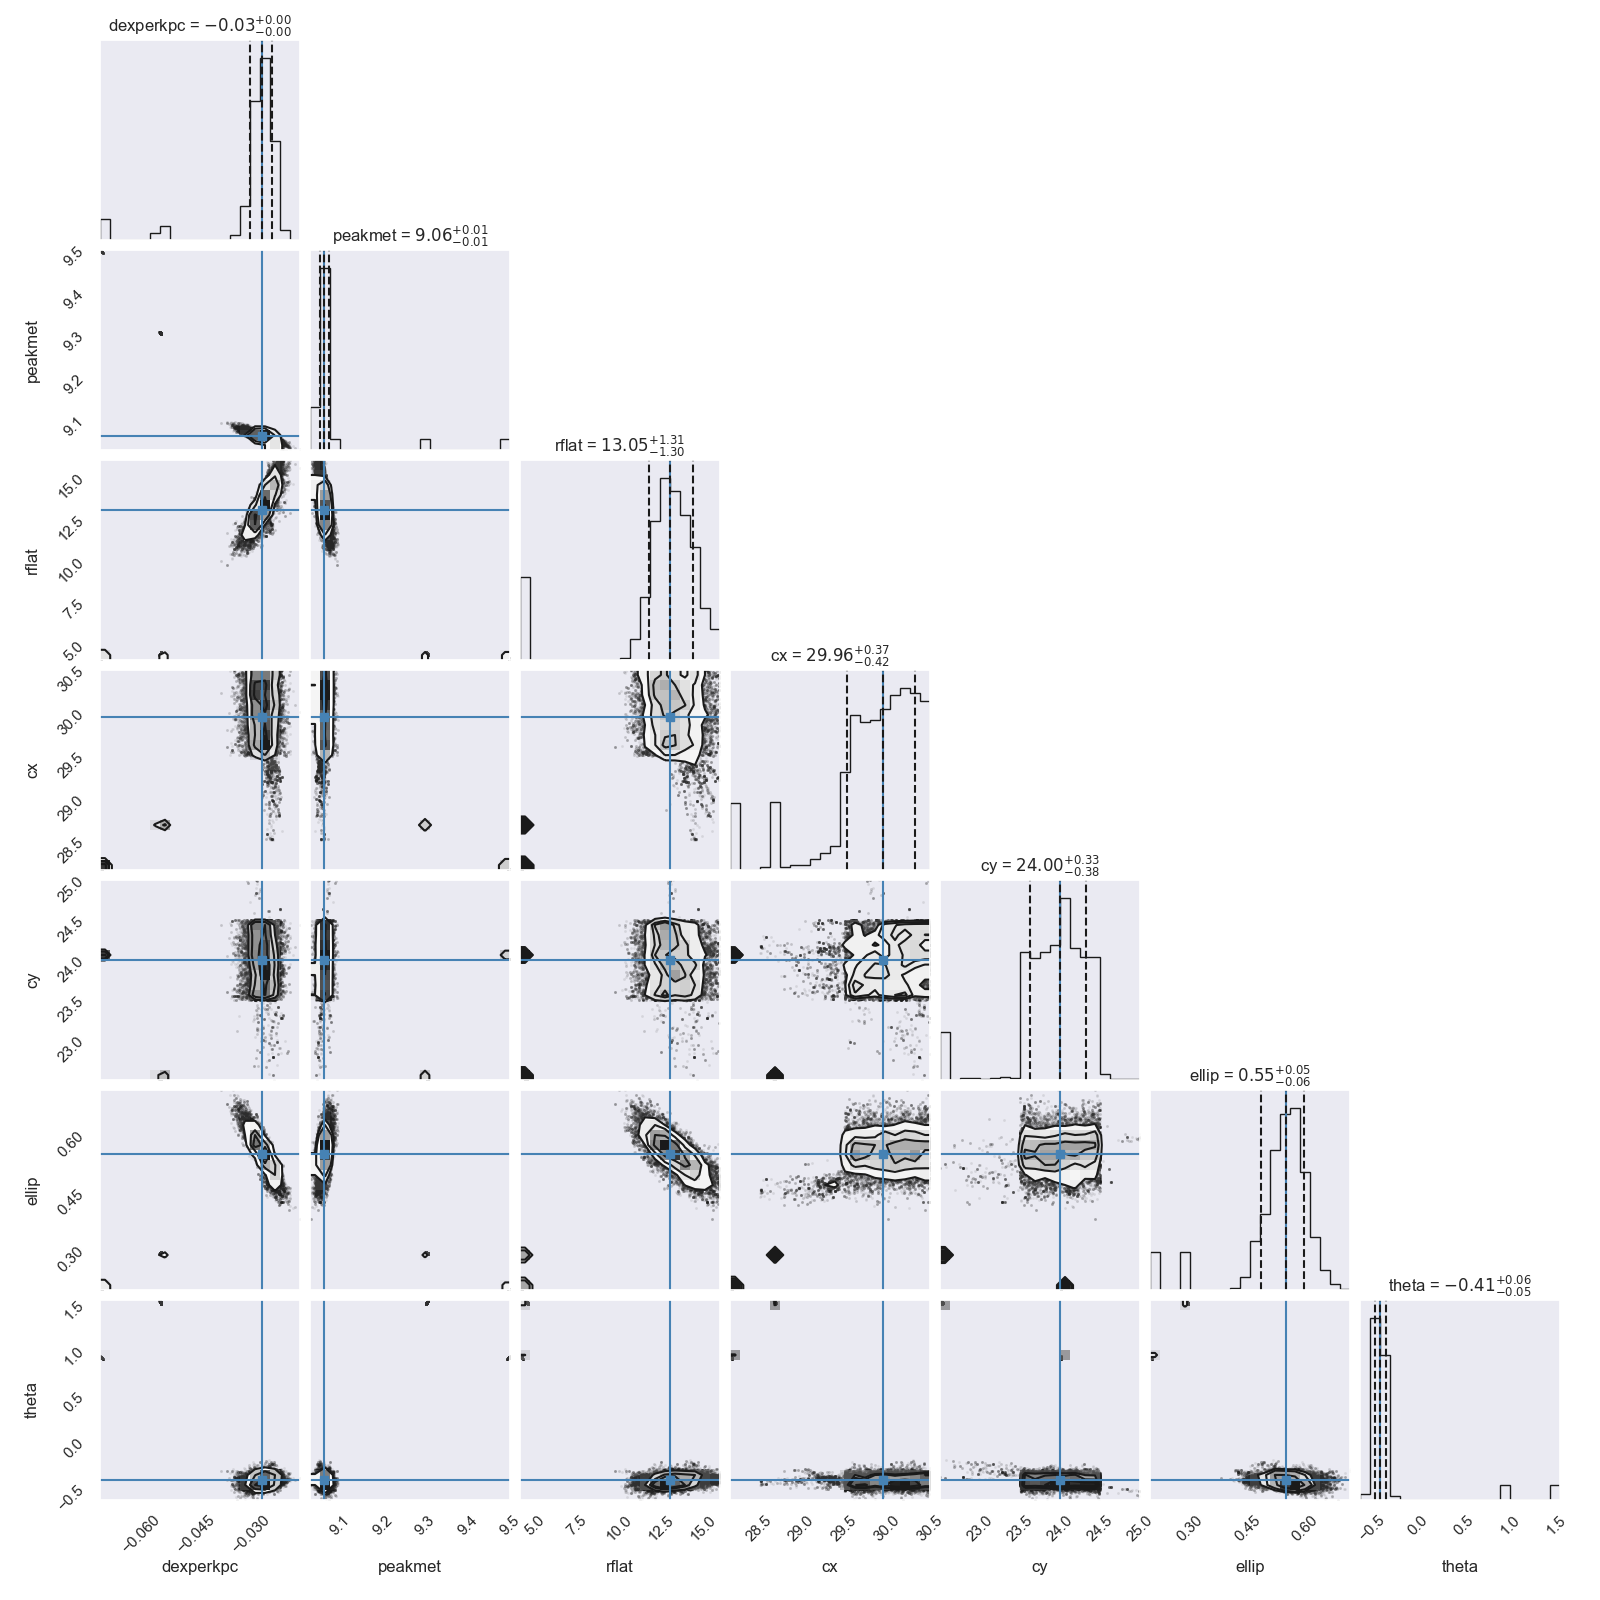

dexperkpc -0.0270$^{+0.0026}_{-0.0033}$
peakmet 9.0620$^{+0.0115}_{-0.0094}$
rflat 13.0489$^{+1.3120}_{-1.2970}$
cx 29.9564$^{+0.3690}_{-0.4218}$
cy 23.9961$^{+0.3275}_{-0.3757}$
ellip 0.5484$^{+0.0468}_{-0.0642}$
theta -0.4145$^{+0.0615}_{-0.0536}$
input to make_2d_plot
-0.03, 9.06, 13.05, 29.96, 24.00, 0.55, -0.41 


In [18]:
fig1 = check_convergence('as1063_2Dfit_flat')
fig2 = make_cornerplot('as1063_2Dfit_flat',500)

<IPython.core.display.Javascript object>


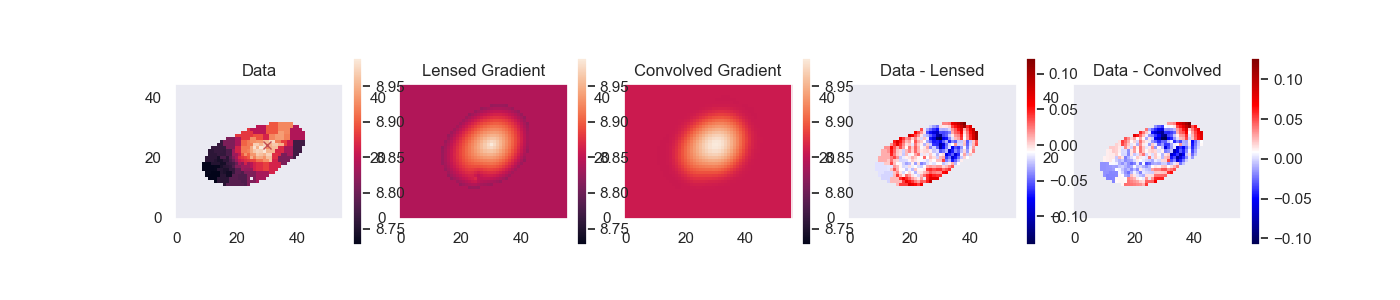

Chi2: 92.83; Chi2/dof: 0.72
Loglikelihood: 507; BIC: -979
Median Absolute Deviation 0.013306


In [19]:
lens_flat, conv_flat,dist_flat = \
        plot_best_solution(dexperkpc= -0.0270 ,peakmet = 9.0620, cx = 30 ,cy = 24 ,ellip = 0.5484 ,theta = -0.4145 , rflat= 13.0489,
                           free_par = 7,
                           data_path= 'Maps/Map_metallicity.fits',
                           uncertainty_path = 'Maps/Map_metallicity_unc.fits',
                           dplx_path = '../../Data/Lensing/AS1063/AS1063_dplx.fits',
                           dply_path = '../../Data/Lensing/AS1063/AS1063_dply.fits',
                           z = 0.611 , 
                           seeing_fwhm_pix = 1.03/0.2,
                           voronoi_path = 'Maps/Map_bins_SN_70_flux_stddev.fits')

fits.writeto('Model_AS1063_with_flatenning_convolved.fits',conv_flat,header=header,overwrite=True)
fits.writeto('Model_AS1063_with_flatenning.fits',lens_flat,header=header,overwrite=True)
fits.writeto('Model_AS1063_with_flatenning_distance.fits',dist_flat,header=header,overwrite=True)

**Summary**

Grad only:
    dexperkpc -0.0227$^{+0.0023}_{-0.0020}$
    peakmet 9.0395$^{+0.0077}_{-0.0076}$
    ellip 0.5381$^{+0.0419}_{-0.0485}$
    theta -0.3925$^{+0.0397}_{-0.0369}$

With Flat:
    dexperkpc -0.0270$^{+0.0026}_{-0.0033}$
    peakmet 9.0620$^{+0.0115}_{-0.0094}$
    ellip 0.5484$^{+0.0468}_{-0.0642}$
    theta -0.4145$^{+0.0615}_{-0.0536}$
    rflat 13.0489$^{+1.3120}_{-1.2970}$

 
Grad only:

    Chi2: 119.62; Chi2/dof: 0.92
    Loglikelihood: 493; BIC: -957
    Median Absolute Deviation 0.018142

With Flat:

    Chi2: 92.83; Chi2/dof: 0.72
    Loglikelihood: 507; BIC: -979
    Median Absolute Deviation 0.013306

    
    
$\Delta$BIC: -957+979 = 22


**TESTS with new convolution**

<IPython.core.display.Javascript object>


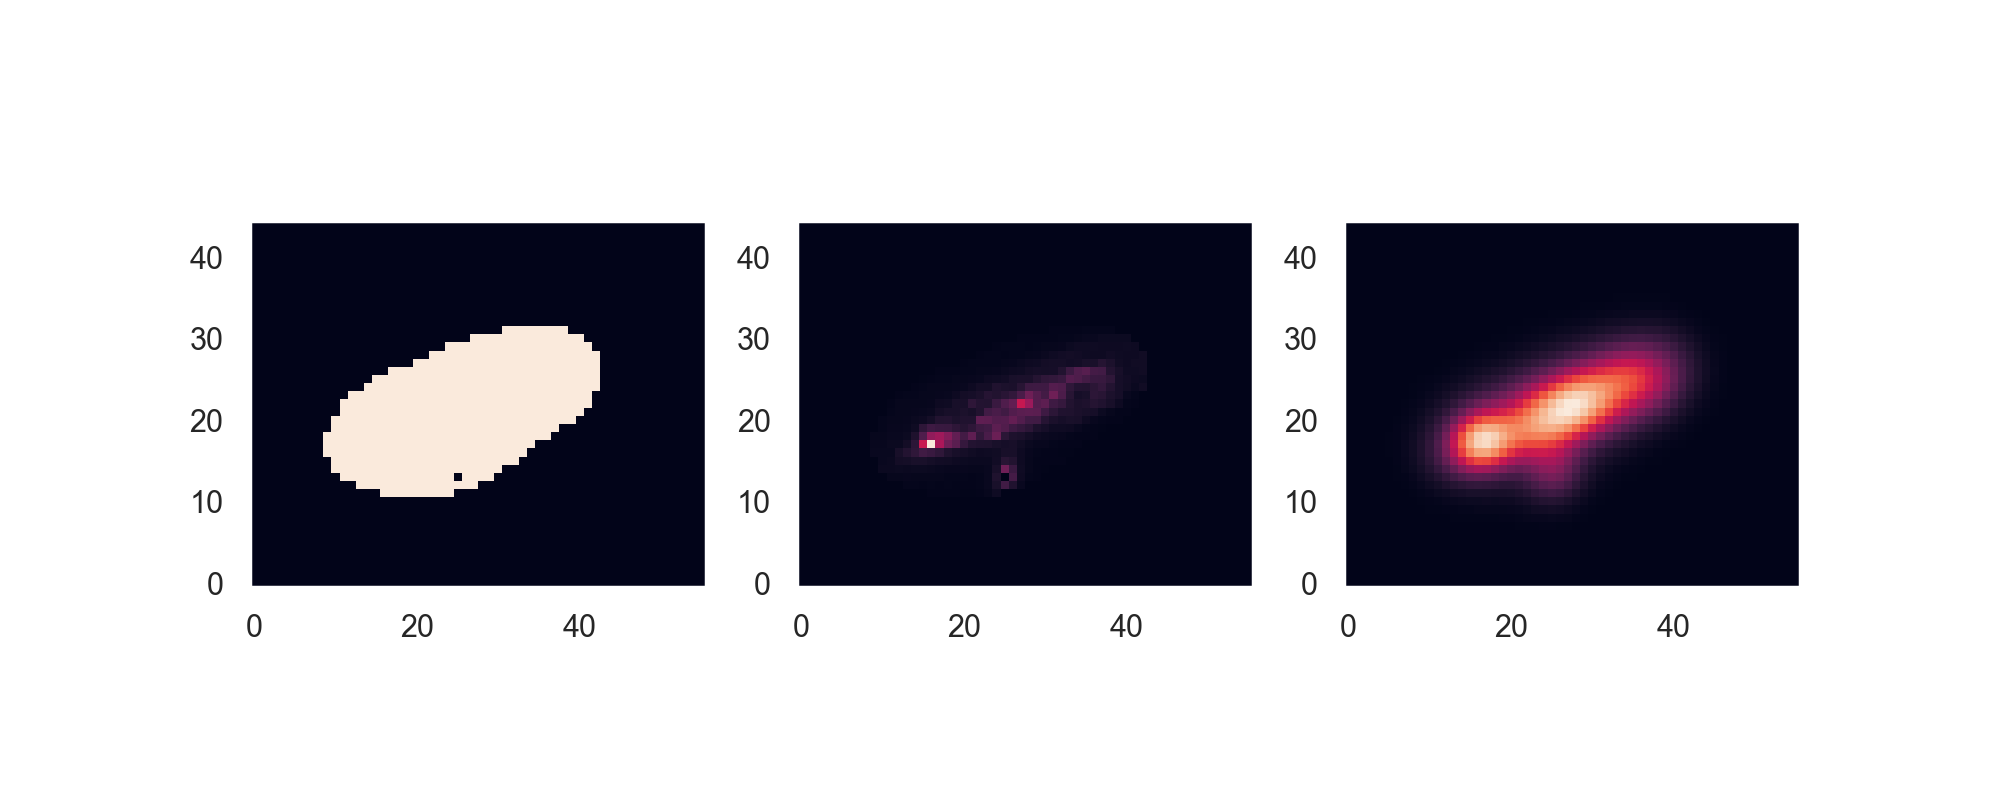

<IPython.core.display.Javascript object>


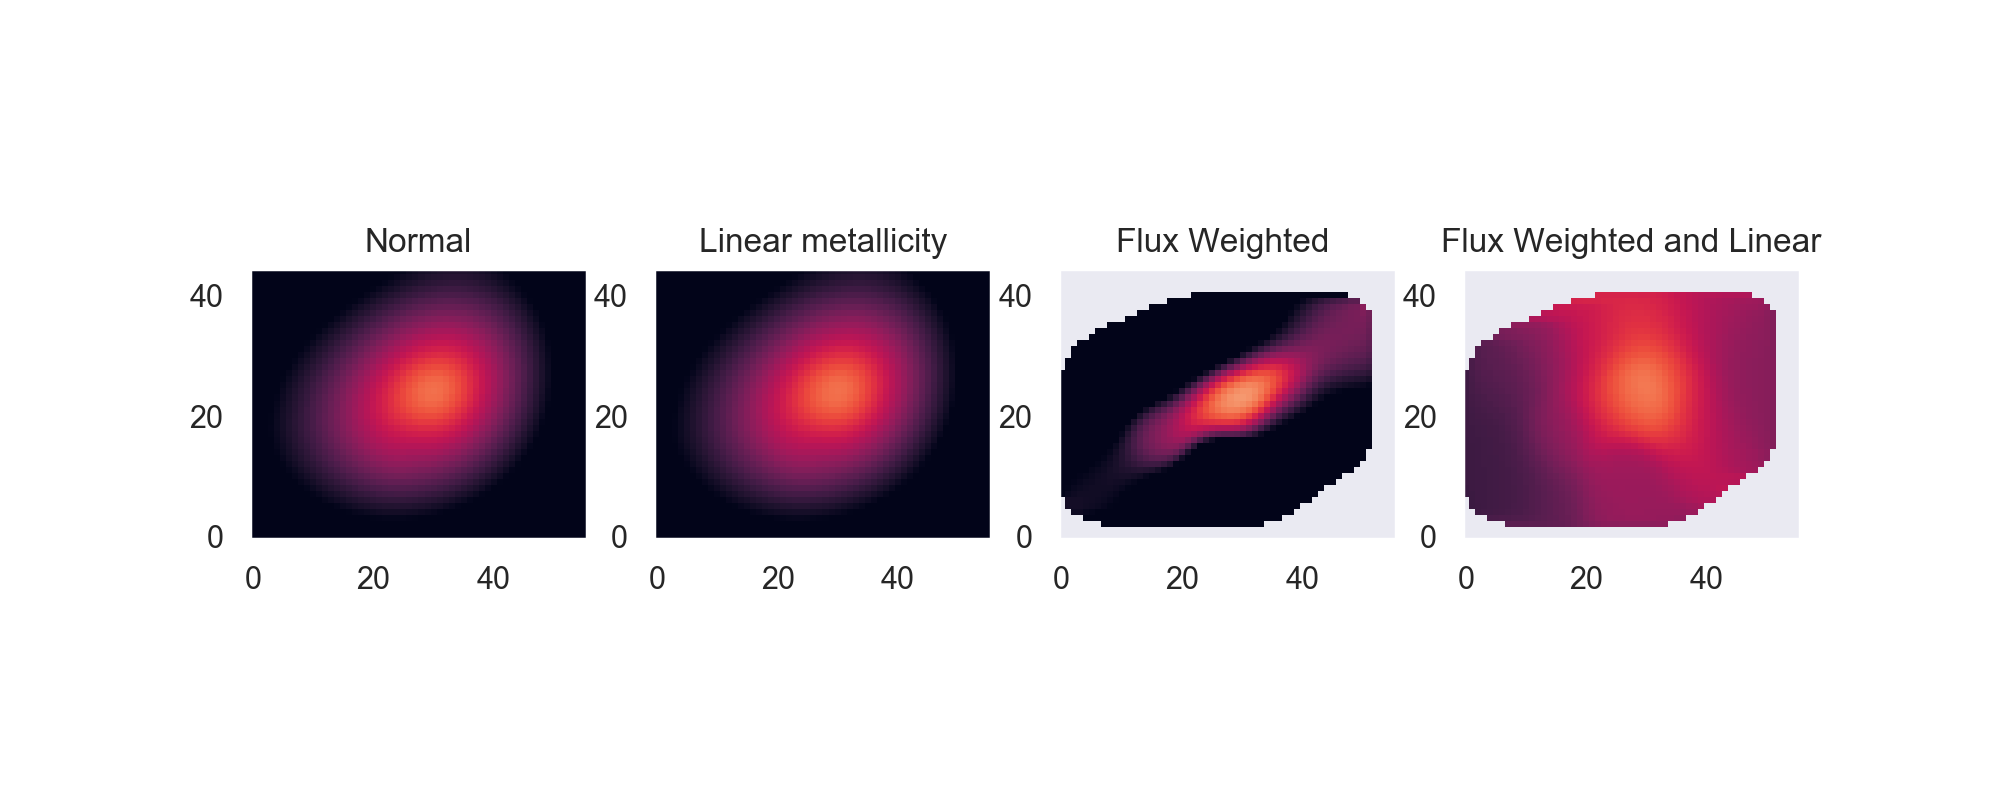

<IPython.core.display.Javascript object>


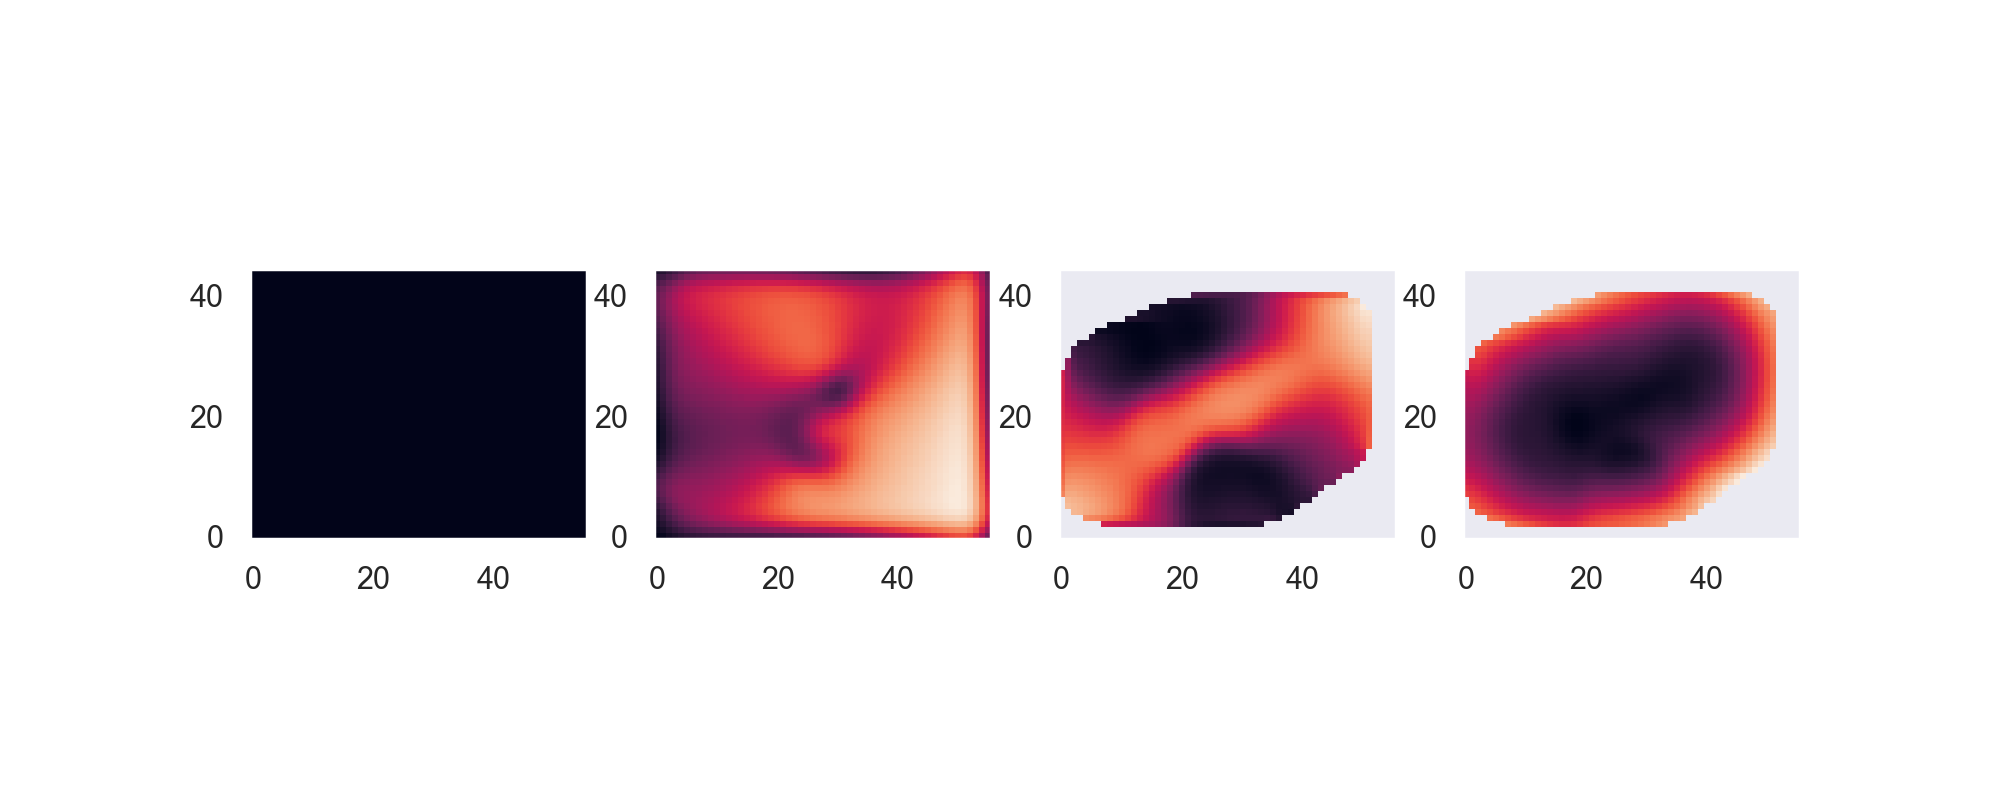

In [90]:
data_path= 'Maps/Map_metallicity.fits'
uncertainty_path = 'Maps/Map_metallicity_unc.fits'
dplx_path = '../../Data/Lensing/AS1063/AS1063_dplx.fits'
dply_path = '../../Data/Lensing/AS1063/AS1063_dply.fits'
voronoi_path = 'Maps/Map_bins_SN_70_flux_stddev.fits'  
seeing_fwhm_pix = 1.03/0.2
    
# Load data
data = fits.getdata(data_path)
data_header = fits.getheader(data_path)
data_shape = data.shape
unc = fits.getdata(uncertainty_path)
dplx = fits.getdata(dplx_path)
dply = fits.getdata(dply_path)
dpl_header = fits.getheader(dplx_path)
voronoi_map = fits.getdata(voronoi_path)
sxmodel,symodel = prepare_displacement_maps(dplx_path,dply_path,data_path,z=0.611)
    
# Prepare gradient map
dexperkpc= -0.0270 
peakmet = 9.0620
cx = 30 
cy = 24 
ellip = 0.5484 
theta = -0.4145
rflat=100
lensed_dist = lensed_distance_map(cx,cy,ellip,theta,rflat,data_shape,sxmodel,symodel)  
lensed_grad = lensed_dist * dexperkpc + peakmet

# Fluxe maps
mask = np.ones_like(voronoi_map)
mask[np.where(voronoi_map == -1 )] = 0
flux_map,_    = reproject_interp('../../Data/HST/AS1063_F814w.fits',fits.getheader('Maps/Map_metallicity.fits'))
flux_map[np.where(np.isnan(flux_map))] = 0
flux_map *= mask

flux_map_conv = convolve(flux_map,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')
'''flux_map[np.where(np.isnan(flux_map))] = 0
flux_map_conv[np.where(np.isnan(flux_map_conv))] = 0
flux_map *= mask
flux_map_conv *= mask
flux_map[np.where(flux_map == 0)] = np.nan
flux_map_conv[np.where(flux_map_conv == 0)] = np.nan'''


fig, ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(mask,origin='lower')
ax[1].imshow(flux_map,origin='lower')
ax[2].imshow(flux_map_conv,origin='lower')

# Normal convolution
normal_conv = convolve(lensed_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend') 

# Linear convolution
linear_grad = 10**(lensed_grad)
linear_conv = np.log10(convolve(linear_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend'))

# Weighted convolution
wght_conv = convolve(lens_grad*flux_map,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')/flux_map_conv

# linear and weighted
linear_and_wght_grad = np.log10(convolve(linear_grad*flux_map,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')/flux_map_conv)

fig, ax = plt.subplots(1,4,figsize=(10,4))
ax[0].set_title('Normal')
ax[1].set_title('Linear metallicity')
ax[2].set_title('Flux Weighted ')
ax[3].set_title('Flux Weighted and Linear')

ax[0].imshow(normal_conv,vmin=8.5,vmax=9.2,origin='lower')
ax[1].imshow(linear_conv,vmin=8.5,vmax=9.2,origin='lower')
ax[2].imshow(wght_conv,vmin=8.5,vmax=9.2,origin='lower')
ax[3].imshow(linear_and_wght_grad,vmin=8.5,vmax=9.2,origin='lower')

fig, ax = plt.subplots(1,4,figsize=(10,4))
ax[0].imshow(normal_conv/normal_conv,origin='lower')
ax[1].imshow(linear_conv/normal_conv,origin='lower')
ax[2].imshow(wght_conv/normal_conv,origin='lower')
ax[3].imshow(linear_and_wght_grad/normal_conv,origin='lower')

<IPython.core.display.Javascript object>


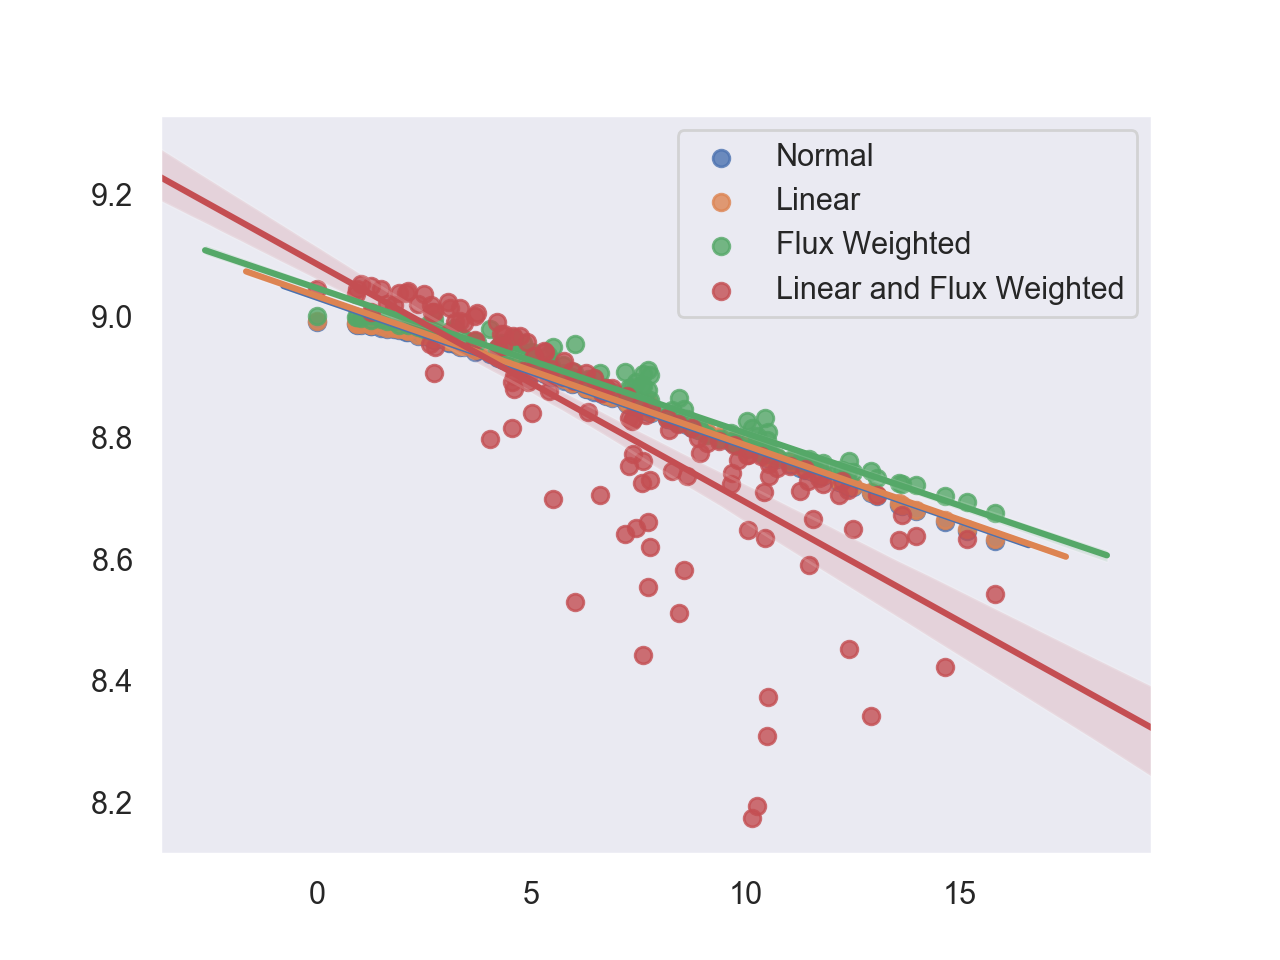

In [91]:
voronoi_map[np.where(voronoi_map==-1)] = np.nan
bins = np.unique(voronoi_map)
bins = bins[~np.isnan(bins)]

def measure_in_vbins(im,stat):
    if stat == 'mean':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])
    if stat == 'std':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[2] for v in bins ])
    
# several convolutions
normal_vbin      = measure_in_vbins(normal_conv,'mean')
linear_vbin      = measure_in_vbins(linear_conv,'mean')
wght_vbin        = measure_in_vbins(linear_and_wght_grad,'mean')
linear_wght_vbin = measure_in_vbins(wght_conv,'mean')

# Morphology
dist_vbin     = measure_in_vbins(lensed_dist,'mean')
dist_vbin_std = measure_in_vbins(lensed_dist,'std')

plt.figure()
sns.regplot(dist_vbin,normal_vbin,label='Normal')
sns.regplot(dist_vbin,linear_vbin,label='Linear')
sns.regplot(dist_vbin,wght_vbin,label='Flux Weighted')
sns.regplot(dist_vbin,linear_wght_vbin,label='Linear and Flux Weighted')

plt.legend()

flux weighted with MUSE white light

<IPython.core.display.Javascript object>


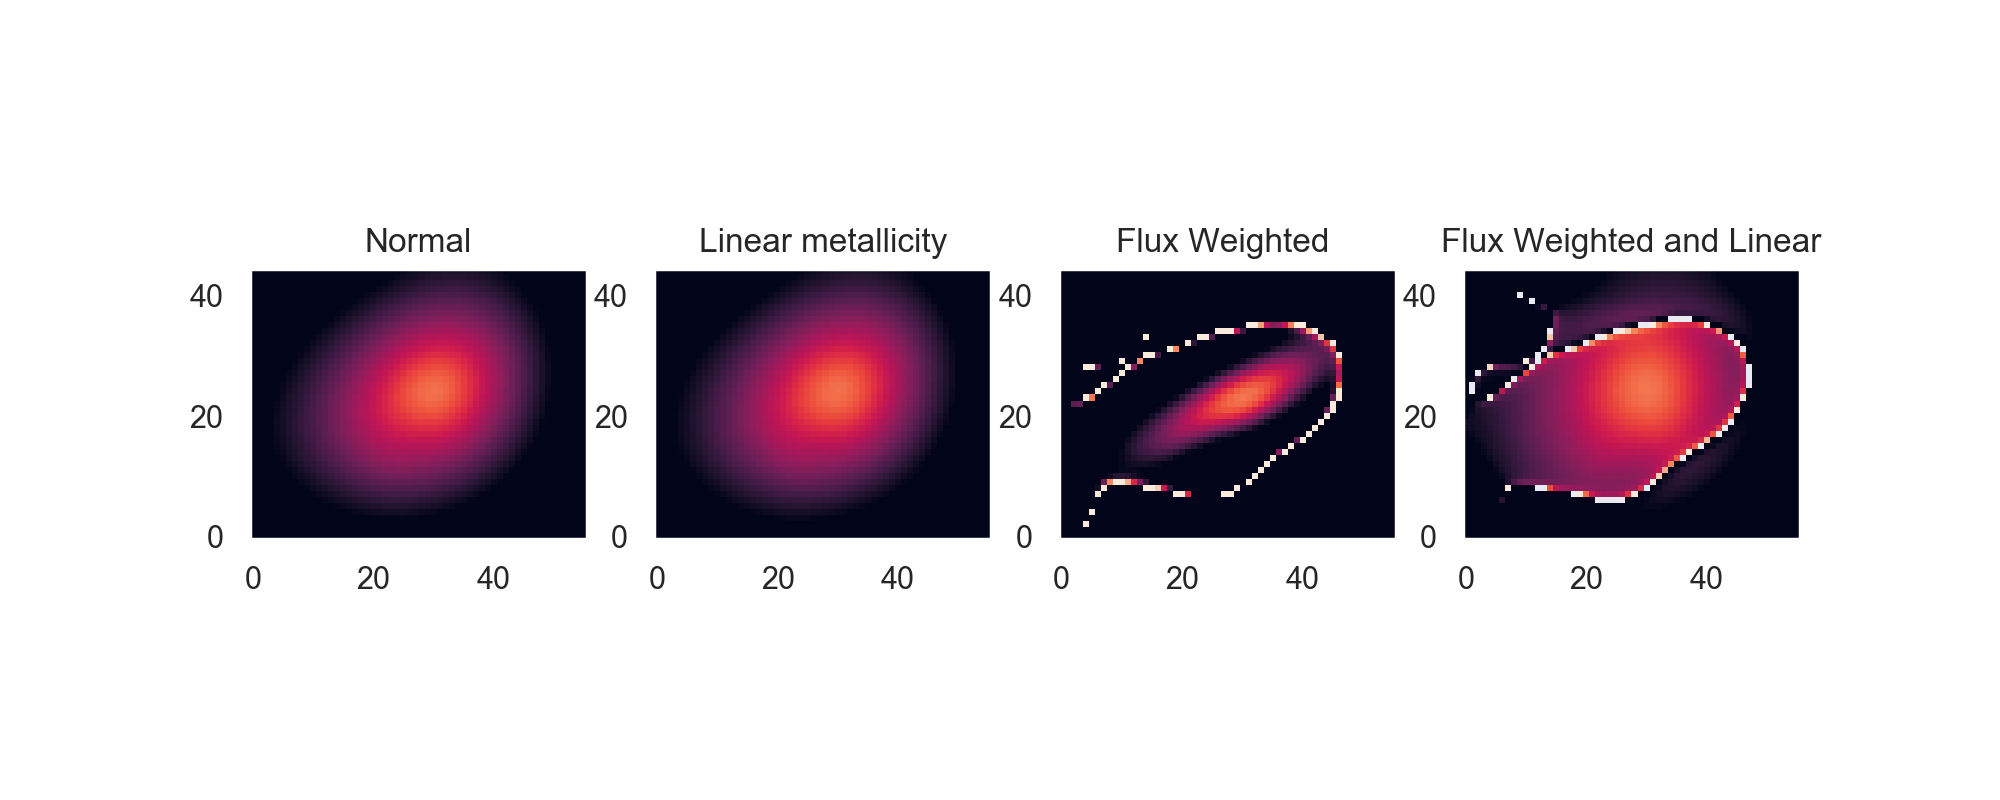

In [54]:
# Normal convolution
normal_conv = convolve(lensed_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend') 

# Linear convolution
linear_grad = 10**(lensed_grad)
linear_conv = np.log10(convolve(linear_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend'))

flux_map_muse = fits.getdata('../../Data/Images/AS1063/Im_AS1063_white_light.fits')
flux_map_muse_conv = flux_map_conv = convolve(flux_map_muse,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')

# Weighted convolution
wght_conv = convolve(lens_grad*flux_map_muse,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')/flux_map_muse_conv

# linear and weighted
linear_and_wght_grad = np.log10(convolve(linear_grad*flux_map_muse,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')/flux_map_muse_conv)

fig, ax = plt.subplots(1,4,figsize=(10,4))
ax[0].set_title('Normal')
ax[1].set_title('Linear metallicity')
ax[2].set_title('Flux Weighted ')
ax[3].set_title('Flux Weighted and Linear')

ax[0].imshow(normal_conv,vmin=8.5,vmax=9.2,origin='lower')
ax[1].imshow(linear_conv,vmin=8.5,vmax=9.2,origin='lower')
ax[2].imshow(wght_conv,vmin=8.5,vmax=9.2,origin='lower')
ax[3].imshow(linear_and_wght_grad,vmin=8.5,vmax=9.2,origin='lower')

<IPython.core.display.Javascript object>


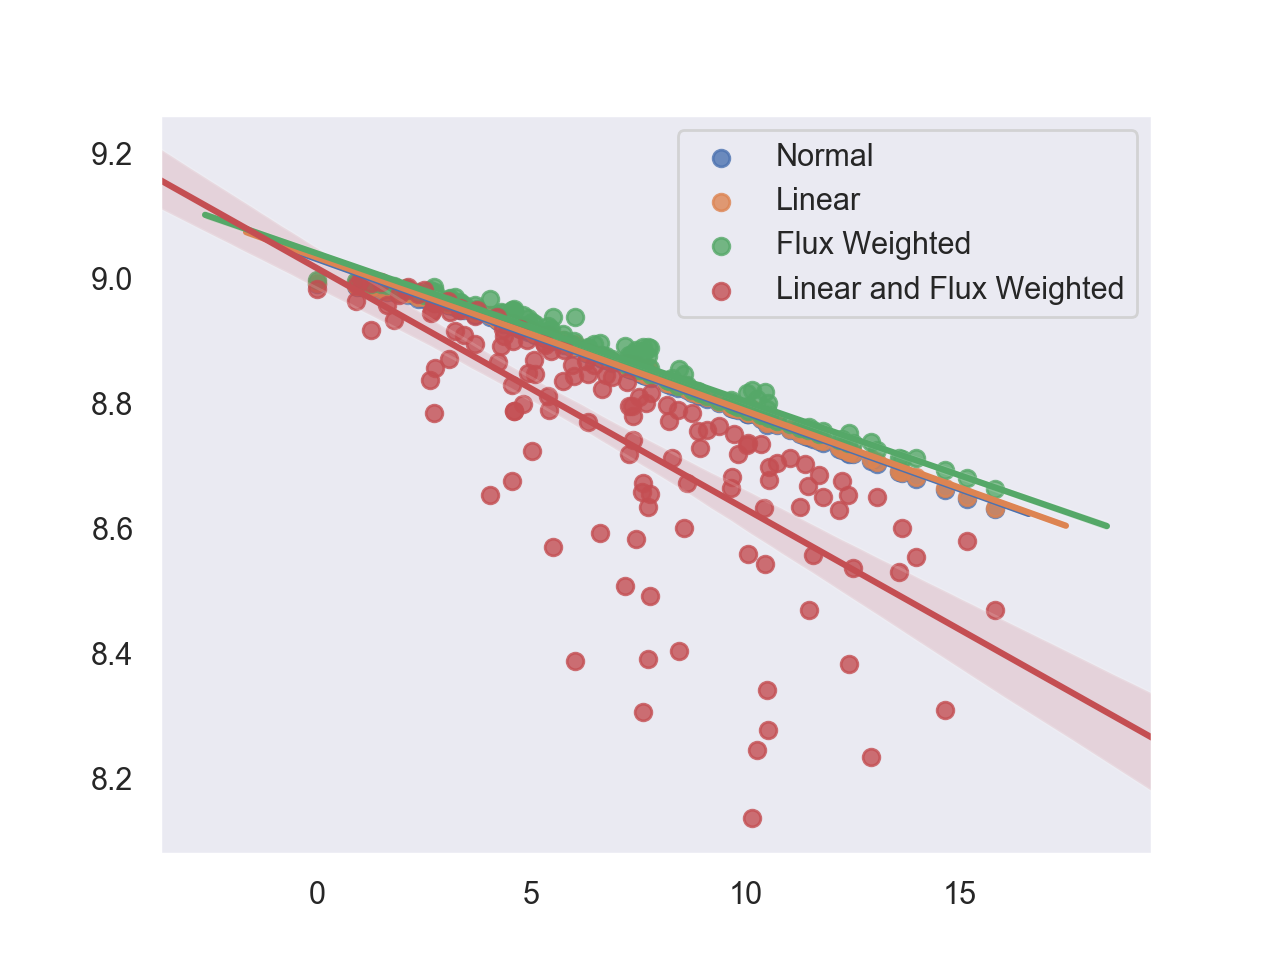

In [55]:
# several convolutions
normal_vbin      = measure_in_vbins(normal_conv,'mean')
linear_vbin      = measure_in_vbins(linear_conv,'mean')
wght_vbin        = measure_in_vbins(linear_and_wght_grad,'mean')
linear_wght_vbin = measure_in_vbins(wght_conv,'mean')

# Morphology
dist_vbin     = measure_in_vbins(lensed_dist,'mean')
dist_vbin_std = measure_in_vbins(lensed_dist,'std')

plt.figure()
sns.regplot(dist_vbin,normal_vbin,label='Normal')
sns.regplot(dist_vbin,linear_vbin,label='Linear')
sns.regplot(dist_vbin,wght_vbin,label='Flux Weighted')
sns.regplot(dist_vbin,linear_wght_vbin,label='Linear and Flux Weighted')

plt.legend()

### Plot the results in 1D to be able to better discuss them

Load data again to avoid issues

In [11]:
met_map = fits.getdata('Maps/Map_metallicity.fits')
emet_map = fits.getdata('Maps/Map_metallicity_unc.fits')
conv_grad = fits.getdata('Model_AS1063_gradient_convolved.fits')
conv_flat = fits.getdata('Model_AS1063_with_flatenning_convolved.fits')
#dist_map_flat = fits.getdata('Model_AS1063_with_flatenning_distance.fits')
dist_map_grad = fits.getdata('Model_AS1063_gradient_distance_map.fits')
dist_map_flat,_ = reproject_interp('../../Data/Lensing/AS1063/simul_AS1063_distance_kpc_source_plane_HST.fits',
                                  fits.getheader('Maps/Map_metallicity.fits'))
dist_map_flat[np.where(dist_map_flat==0)] = np.nan
ang_map = reproject_interp('../../Data/Lensing/AS1063/simul_AS1063_azimuth_map_source_plane.fits',fits.getheader('Maps/Map_metallicity.fits'),order=0)[0]
ang_map[np.where(ang_map==0)] = np.nan
sect_map_ip = fits.getdata('Maps/Map_sectors.fits')
voronoi_map = fits.getdata('map_bins_SN_70_flux_stddev.fits')
header_ip = fits.getheader('Maps/Map_metallicity.fits')
res_map_grad = met_map - conv_grad
res_map_flat= met_map - conv_flat

<IPython.core.display.Javascript object>


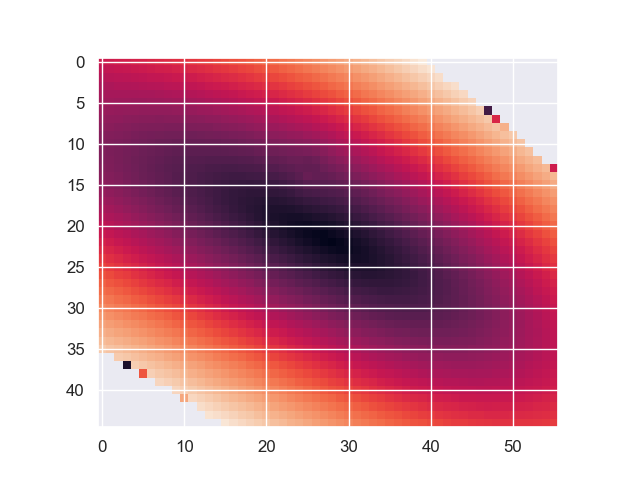

In [12]:
plt.figure()
plt.imshow(dist_map_flat)

Extract data

In [13]:
voronoi_map[np.where(voronoi_map==-1)] = np.nan
bins = np.unique(voronoi_map)
bins = bins[~np.isnan(bins)]

def measure_in_vbins(im,stat):
    if stat == 'mean':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])
    if stat == 'std':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[2] for v in bins ])

# Metallicity
met_vbin     = measure_in_vbins(met_map,'mean')
emet_vbin    = measure_in_vbins(emet_map,'mean')
met_vbin_std = measure_in_vbins(met_map,'std') 
met_vbin_err = np.sqrt(emet_vbin**2 + met_vbin_std**2)

# Model
model_grad_vbin     = measure_in_vbins(conv_grad,'mean')
model_grad_vbin_std = measure_in_vbins(conv_grad,'std')
model_flat_vbin     = measure_in_vbins(conv_flat,'mean')
model_flat_vbin_std = measure_in_vbins(conv_flat,'std')

# Residuals
res_grad_vbin = measure_in_vbins(res_map_grad,'mean') 
res_flat_vbin = measure_in_vbins(res_map_flat,'mean') 

# Morphology
dist_vbin_grad     = measure_in_vbins(dist_map_grad,'mean')
dist_vbin_std_grad = measure_in_vbins(dist_map_grad,'std')
dist_vbin_flat     = measure_in_vbins(dist_map_flat,'mean')
dist_vbin_std_flat = measure_in_vbins(dist_map_flat,'std')

ang_vbin     = measure_in_vbins(ang_map,'mean')
ang_std_vbin = measure_in_vbins(ang_map,'std')

size_vbin   = np.array([len(np.atleast_1d(np.where(voronoi_map==v)[0])) for v in bins ])
sector_vbin = np.array([sigma_clipped_stats(sect_map_ip[np.where(voronoi_map==v)])[0] for v in bins ])

Plot data vs model, binned (in radius) data and model and the residuals.

Fit the residuals to see if there is a tail.

In [14]:
def bin_data_r(data,dist):
    binned_data, bin_edges, bin_number = binned_statistic(dist,data,'mean',bins=range(0,18))
    binned_err, bin_edges, bin_number = binned_statistic(dist,data,'std',bins=range(0,18))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

def bin_data_ang(data):
    binned_data, bin_edges, bin_number = binned_statistic(ang_vbin,data,'mean',bins=range(0,360,20))
    binned_err, bin_edges, bin_number = binned_statistic(ang_vbin,data,'std',bins=range(0,360,20))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

**Full data**

<IPython.core.display.Javascript object>


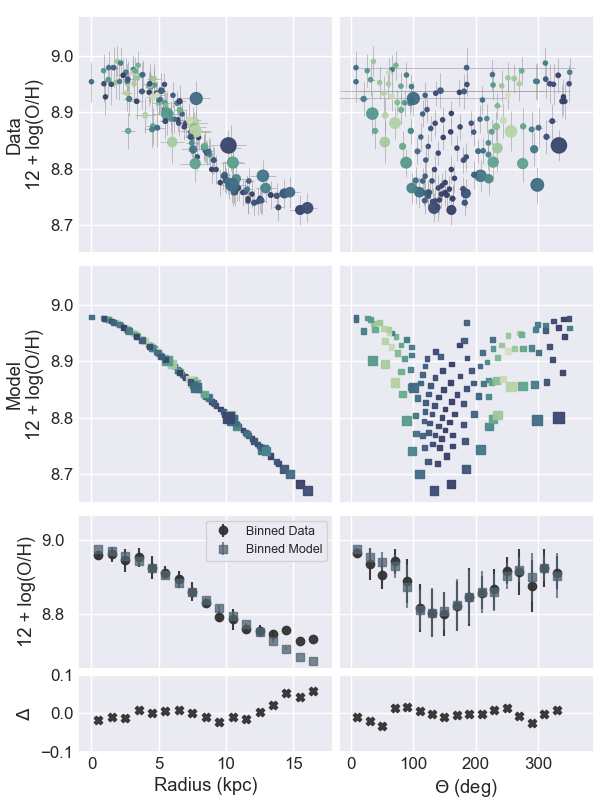

('MAD radial ', 0.012066032655313919)


In [5]:
# Set plotting style
sns.set_style('darkgrid')
sns.set(font_scale=1.1)
cmap_sectors = sns.cubehelix_palette(5, start=.5, rot=-.75,dark=0.25,reverse=True,as_cmap=True)

## Set figure
fig, ax = plt.subplots(3,2,figsize=(6,8))
#fig.suptitle('AS1063-sys1 2D fit: Data vs Model')
fig.subplots_adjust(top=0.98,left=0.13,right=0.99,wspace=0.02,hspace=0.05,bottom=0.06)
ax = ax.ravel()
gs4 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[4],height_ratios=[2,1])
gs40 = plt.Subplot(fig, gs4[0])
fig.add_subplot(gs40)
gs41 = plt.Subplot(fig, gs4[1])
fig.add_subplot(gs41)
ax[4].axis('off')
gs5 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[5],height_ratios=[2,1])
gs50 = plt.Subplot(fig, gs5[0])
fig.add_subplot(gs50)
gs51 = plt.Subplot(fig, gs5[1])
fig.add_subplot(gs51)
ax[5].axis('off')

## Axis and labels
ax[0].set_ylim(8.65,9.07)
ax[2].set_ylim(8.65,9.07)
gs40.set_ylim(8.65,9.07)
ax[1].set_ylim(8.65,9.07)
ax[3].set_ylim(8.65,9.07)
gs50.set_ylim(8.65,9.07)

gs41.set_ylim(-0.1,0.1)
gs51.set_ylim(-0.1,0.1)

ax[0].set_xlim(-1,18)
ax[2].set_xlim(-1,18)
gs40.set_xlim(-1,18)
gs41.set_xlim(-1,18)
ax[1].set_xlim(-20,390)
ax[3].set_xlim(-20,390)
gs50.set_xlim(-20,390)
gs51.set_xlim(-20,390)

ax[0].set_ylabel('Data\n12 + log(O/H)')
ax[2].set_ylabel('Model\n12 + log(O/H)')
gs40.set_ylabel('12 + log(O/H)')
gs41.set_ylabel('$\Delta$')

gs41.set_xlabel('Radius (kpc)')
gs51.set_xlabel('$\Theta$ (deg)')

ax[0].tick_params(labelbottom=False,direction='in')    
ax[2].tick_params(labelbottom=False,direction='in')  
ax[1].tick_params(labelbottom=False,direction='in',labelleft=False)    
ax[3].tick_params(labelbottom=False,direction='in',labelleft=False)
gs50.tick_params(labelbottom=False,direction='in',labelleft=False) 
gs51.tick_params(direction='in',labelleft=False) 
gs41.tick_params(direction='in') 


## Radial data and model
ax[0].errorbar(dist_vbin_grad, met_vbin, xerr=dist_vbin_std_grad, yerr=met_vbin_err, linestyle='', ecolor='0.6', elinewidth=0.4)
ax[0].scatter(dist_vbin_grad, met_vbin, linewidths=None, alpha=0.95, marker='.', cmap=cmap_sectors, c=sector_vbin, s=size_vbin**2+35,zorder=10)
ax[2].scatter(dist_vbin_grad, model_grad_vbin, linewidths=None, alpha=0.95, marker='s', cmap=cmap_sectors, c=sector_vbin, s=size_vbin**1.3+10)

# Radial residuals
met_rbin, met_std_rbin, dist_rbin = bin_data_r(met_vbin,dist_vbin_grad)
model_rbin, model_std_rbin, dist_rbin = bin_data_r(model_grad_vbin,dist_vbin_grad)
res_rbin = met_rbin - model_rbin
gs40.errorbar(dist_rbin, met_rbin, yerr=met_std_rbin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Binned Data')
gs40.errorbar(dist_rbin, model_rbin, yerr=model_std_rbin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Binned Model')
gs41.scatter(dist_rbin, res_rbin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')
gs40.legend(fontsize=9)

print('MAD radial ',median_absolute_deviation(res_rbin,ignore_nan=True))

## Azimuthal Data and Model
ax[1].errorbar(ang_vbin,met_vbin,xerr=ang_std_vbin,yerr=met_vbin_err,linestyle='',ecolor='0.6',elinewidth=0.4)
ax[1].scatter(ang_vbin,met_vbin,linewidths=None,alpha=0.95,marker='.',cmap=cmap_sectors,c=sector_vbin,s=size_vbin**2+35,zorder=10)
ax[3].scatter(ang_vbin,model_grad_vbin,linewidths=None,alpha=0.95,marker='s',cmap=cmap_sectors,c=sector_vbin,s=size_vbin**1.3+10)

## Azimuthal Residuals 
met_abin, met_std_abin, ang_abin = bin_data_ang(met_vbin)
model_abin, model_std_abin, ang_abin = bin_data_ang(model_grad_vbin)
res_abin = met_abin - model_abin
gs50.errorbar(ang_abin, met_abin, yerr=met_std_abin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Data')
gs50.errorbar(ang_abin, model_abin, yerr=model_std_abin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Model')
gs51.scatter(ang_abin, res_abin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')

#fig.savefig('../../Plots/AS1063_2Dfit.pdf')

**With flatenning gradient**

<IPython.core.display.Javascript object>


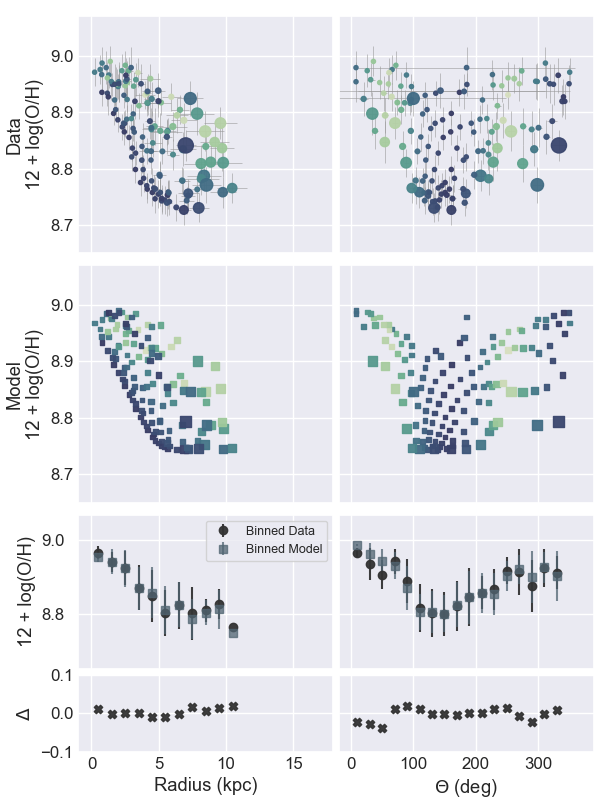

('MAD radial ', 0.008912100358580588)


In [15]:
# Set plotting style
sns.set_style('darkgrid')
sns.set(font_scale=1.1)
cmap_sectors = sns.cubehelix_palette(5, start=.5, rot=-.75,dark=0.25,reverse=True,as_cmap=True)

## Set figure
fig, ax = plt.subplots(3,2,figsize=(6,8))
#fig.suptitle('AS1063-sys1 2D fit: Data vs Model')
fig.subplots_adjust(top=0.98,left=0.13,right=0.99,wspace=0.02,hspace=0.05,bottom=0.06)
ax = ax.ravel()
gs4 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[4],height_ratios=[2,1])
gs40 = plt.Subplot(fig, gs4[0])
fig.add_subplot(gs40)
gs41 = plt.Subplot(fig, gs4[1])
fig.add_subplot(gs41)
ax[4].axis('off')
gs5 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[5],height_ratios=[2,1])
gs50 = plt.Subplot(fig, gs5[0])
fig.add_subplot(gs50)
gs51 = plt.Subplot(fig, gs5[1])
fig.add_subplot(gs51)
ax[5].axis('off')


## Axis and labels
ax[0].set_ylim(8.65,9.07)
ax[2].set_ylim(8.65,9.07)
gs40.set_ylim(8.65,9.07)
ax[1].set_ylim(8.65,9.07)
ax[3].set_ylim(8.65,9.07)
gs50.set_ylim(8.65,9.07)

gs41.set_ylim(-0.1,0.1)
gs51.set_ylim(-0.1,0.1)

ax[0].set_xlim(-1,18)
ax[2].set_xlim(-1,18)
gs40.set_xlim(-1,18)
gs41.set_xlim(-1,18)
ax[1].set_xlim(-20,390)
ax[3].set_xlim(-20,390)
gs50.set_xlim(-20,390)
gs51.set_xlim(-20,390)

ax[0].set_ylabel('Data\n12 + log(O/H)')
ax[2].set_ylabel('Model\n12 + log(O/H)')
gs40.set_ylabel('12 + log(O/H)')
gs41.set_ylabel('$\Delta$')

gs41.set_xlabel('Radius (kpc)')
gs51.set_xlabel('$\Theta$ (deg)')

ax[0].tick_params(labelbottom=False,direction='in')    
ax[2].tick_params(labelbottom=False,direction='in')  
ax[1].tick_params(labelbottom=False,direction='in',labelleft=False)    
ax[3].tick_params(labelbottom=False,direction='in',labelleft=False)
gs50.tick_params(labelbottom=False,direction='in',labelleft=False) 
gs51.tick_params(direction='in',labelleft=False) 
gs41.tick_params(direction='in') 


## Radial data and model
ax[0].errorbar(dist_vbin_flat, met_vbin, xerr=dist_vbin_std_flat, yerr=met_vbin_err, linestyle='', ecolor='0.6', elinewidth=0.4)
ax[0].scatter(dist_vbin_flat, met_vbin, linewidths=None, alpha=0.95, marker='.', cmap=cmap_sectors, c=sector_vbin, s=size_vbin**2+35,zorder=10)
ax[2].scatter(dist_vbin_flat, model_flat_vbin, linewidths=None, alpha=0.95, marker='s', cmap=cmap_sectors, c=sector_vbin, s=size_vbin**1.3+10)

# Radial residuals
met_rbin, met_std_rbin, dist_rbin = bin_data_r(met_vbin,dist_vbin_flat)
model_rbin, model_std_rbin, dist_rbin = bin_data_r(model_flat_vbin,dist_vbin_flat)
res_rbin = met_rbin - model_rbin
gs40.errorbar(dist_rbin, met_rbin, yerr=met_std_rbin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Binned Data')
gs40.errorbar(dist_rbin, model_rbin, yerr=model_std_rbin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Binned Model')
gs41.scatter(dist_rbin, res_rbin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')
gs40.legend(fontsize=9)
print('MAD radial ',median_absolute_deviation(res_rbin,ignore_nan=True))


## Azimuthal Data and Model
ax[1].errorbar(ang_vbin,met_vbin,xerr=ang_std_vbin,yerr=met_vbin_err,linestyle='',ecolor='0.6',elinewidth=0.4)
ax[1].scatter(ang_vbin,met_vbin,linewidths=None,alpha=0.95,marker='.',cmap=cmap_sectors,c=sector_vbin,s=size_vbin**2+35,zorder=10)
ax[3].scatter(ang_vbin,model_flat_vbin,linewidths=None,alpha=0.95,marker='s',cmap=cmap_sectors,c=sector_vbin,s=size_vbin**1.3+10)

## Azimuthal Residuals 
met_abin, met_std_abin, ang_abin = bin_data_ang(met_vbin)
model_abin, model_std_abin, ang_abin = bin_data_ang(model_flat_vbin)
res_abin = met_abin - model_abin
gs50.errorbar(ang_abin, met_abin, yerr=met_std_abin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Data')
gs50.errorbar(ang_abin, model_abin, yerr=model_std_abin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Model')
gs51.scatter(ang_abin, res_abin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')


#fig.savefig('../../Plots/AS1063_2Dfit.pdf')
#fig.savefig('/Users/vera/Desktop/AS1063_2Dfit.pdf')

## Measure radial and azimuthal dispersion

radial: Bin data in 500 pc and calculate the dispersion

azimuthal: Bin data in sectors of 10 degrees and calculate the dispersion

In [26]:
from astropy.stats import bootstrap
def bootstrap_for_error(data):
    if len(data) == 0:
        return np.nan,np.nan
    else:
        sample = bootstrap(data, 100, bootfunc=np.std)
        value  = np.quantile(sample,0.5)
        err    =  np.mean((value-np.quantile(sample,0.16),np.quantile(sample,0.84)-value))
        return value,err


# Radial dispersion
model_rdisp = []
met_rdisp = []
res_rdisp = []
model_rerr = []
met_rerr = []
res_rerr = []

for r in np.arange(0,15,0.5):
    
    sel_pix = np.where((dist_vbin_flat>=r) & (dist_vbin_flat < r+0.5))
    
    model_std, model_err = bootstrap_for_error(model_flat_vbin[sel_pix])
    met_std,   met_err   = bootstrap_for_error(met_vbin[sel_pix])   
    res_std,   res_err   = bootstrap_for_error(res_flat_vbin[sel_pix]) 
    
    met_rdisp.append(met_std)
    met_rerr.append(met_err)
    model_rdisp.append(model_std)
    model_rerr.append(model_err)
    res_rdisp.append(res_std)
    res_rerr.append(res_err)
    
met_rdisp = np.array(met_rdisp)
model_rdisp = np.array(model_rdisp)
met_rerr = np.array(met_rerr)
model_rerr = np.array(model_rerr)
res_rdisp = np.array(res_rdisp)
res_rerr = np.array(res_rerr)
res_rdisp2 = met_rdisp - model_rdisp

# Azimuthal dispersion   
model_adisp = []
met_adisp = []
res_adisp = []
model_aerr = []
met_aerr = []
res_aerr = []


for ang in range(0,360,10):
    sel_pix = np.where((ang_vbin>=ang) & (ang_vbin <ang+10))
    
    model_std, model_err = bootstrap_for_error(model_flat_vbin[sel_pix])
    met_std,   met_err   = bootstrap_for_error(met_vbin[sel_pix])   
    res_std,   res_err   = bootstrap_for_error(res_flat_vbin[sel_pix]) 
    
    met_adisp.append(met_std)
    met_aerr.append(met_err)
    model_adisp.append(model_std)
    model_aerr.append(model_err)
    res_adisp.append(res_std)
    res_aerr.append(res_err)
    
met_adisp = np.array(met_adisp)
model_adisp = np.array(model_adisp)
met_aerr = np.array(met_aerr)
model_aerr = np.array(model_aerr)
res_adisp = np.array(res_adisp)
res_aerr = np.array(res_aerr)    

<IPython.core.display.Javascript object>


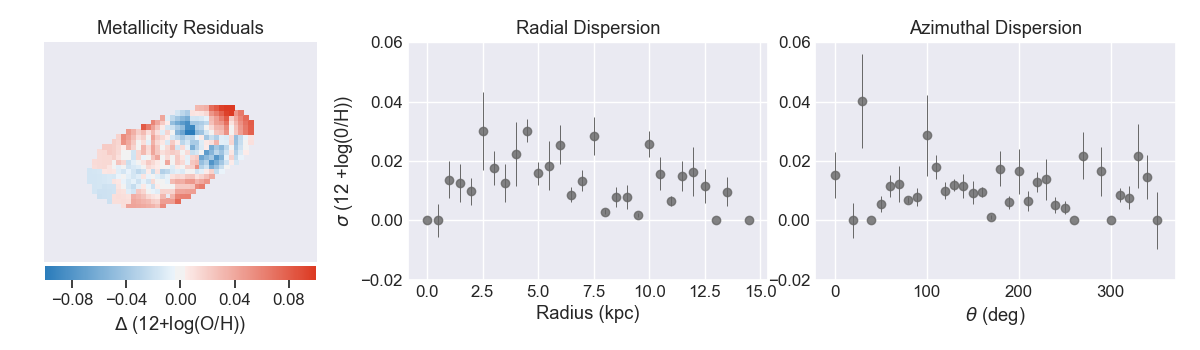

In [37]:
# Plotting
import matplotlib.gridspec as gridspec
sns.set_style('darkgrid')

fig, ax = plt.subplots(1,3,figsize=(12, 3.5))
fig.subplots_adjust(left=0.00,right=0.98,wspace=0.13,bottom=0.2)

# 2D map
cmap_res = sns.diverging_palette(245, 15,s=90, as_cmap=True)
sns.heatmap(res_map_flat,ax=ax[0],robust=True,yticklabels='',xticklabels='',cmap=cmap_res,vmin=-0.1,vmax=0.1,
            cbar_kws = dict(use_gridspec=False,location="bottom",pad = 0.02,fraction=0.057,label='$\Delta$ (12+log(O/H))'))
ax[0].set_aspect("equal")
ax[0].invert_yaxis()
ax[0].set_title('Metallicity Residuals')

# Radial
n_colors = len(np.unique(res_rdisp[np.isfinite(res_rdisp)]))
ax[1].errorbar(np.arange(0,15,0.5),res_rdisp,yerr=res_rerr,elinewidth=0.7,linestyle='',ecolor='0.4')
sns.regplot(np.arange(0,15,0.5),res_rdisp, ax = ax[1],marker='o',color='0.4',truncate=True,fit_reg=False)
'''sns.regplot(np.arange(0,15,0.5),res_rdisp, ax = ax[1],marker='o',color='0.4',truncate=True)
good_pix = np.where(np.isfinite(res_rdisp))
linfit = stats.linregress(np.arange(0,15,0.5)[good_pix],res_rdisp[good_pix])
ax[1].annotate('m = %0.4f dex/kpc\ny${_0}$ = %0.4f dex'%(linfit.slope,linfit.intercept),xy=(0,0.075))'''
ax[1].axhline(np.mean(dist_vbin_std_flat>0))

# Azimuthal
n_colors = len(np.unique(res_adisp[np.isfinite(res_adisp)]))
ax[2].errorbar(range(0,360,10),res_adisp,yerr=res_aerr,elinewidth=0.7,linestyle='',ecolor='0.4')
sns.regplot(range(0,360,10),res_adisp, ax = ax[2],marker='o',truncate=True,color='0.4',fit_reg=False)
'''sns.regplot(range(0,360,10),res_adisp, ax = ax[2],marker='o',truncate=True,color='0.4')
good_pix = np.where(np.isfinite(res_adisp))
linfit = stats.linregress(np.arange(0,360,10)[good_pix],res_adisp[good_pix])
ax[2].annotate('m = %0.4f dex/kpc\ny${_0}$ = %0.4f dex'%(linfit.slope,linfit.intercept),xy=(5,0.075))'''


# Labels and ticks
ax[1].set_ylim(-0.02,0.06)
ax[2].set_ylim(-0.02,0.06)
ax[1].set_title('Radial Dispersion')
ax[2].set_title('Azimuthal Dispersion')

ax[1].set_xlabel('Radius (kpc)')
ax[2].set_xlabel('$\\theta$ (deg)')
ax[1].set_xlabel('Radius (kpc)')

ax[1].tick_params(direction='in')
ax[2].tick_params(direction='in')  
ax[1].set_ylabel('$\sigma$ (12 +log(0/H))')

fig.savefig('../../Plots/AS1063_residuals.pdf')
#fig.savefig('/Users/vera/Desktop/AS1063_residuals.pdf')

In [46]:
print(np.mean(met_vbin_err)) # a lot of zeros, no measurements
print(np.nanmean(res_rdisp))
print(np.nanmean(res_adisp))

0.026555166757197057
0.01314122295255497
0.011000211212390695
